Number of samples: 549 \
Number of each label 0/1: 822000

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.signal import find_peaks
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
from scipy import stats
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, confusion_matrix
import neurokit2 as nk
import seaborn as sns
import pickle

Features Functions:
------

In [3]:
def calculate_bpm_hrv(signals, r_info, sampling_rate=100):
    r_peaks = r_info['ECG_R_Peaks']
    
    rr_intervals = np.diff(r_peaks) / sampling_rate

    if len(rr_intervals) == 0:
        return None, r_peaks 
    
    hrv = np.std(rr_intervals)
    
    bpm_values = 60 / rr_intervals
    bpm = np.mean(bpm_values)
    hr_sd = np.std(bpm_values)
    mean_rr = np.mean(rr_intervals)
    
    return bpm, mean_rr, r_peaks, hrv, hr_sd

def calculate_qrs_duration(signals, r_info, sampling_rate=100):
    q_peaks = np.where(signals['ECG_Q_Peaks'] == 1)[0]  # indices of Q-peaks
    s_peaks = np.where(signals['ECG_S_Peaks'] == 1)[0]  # indices of S-peaks
    
    qrs_durations = []
    for r in r_info['ECG_R_Peaks']:
        # find the closest Q-peak before the R-peak
        q_candidates = q_peaks[q_peaks < r]
        if len(q_candidates) > 0:
            q_peak = q_candidates[-1]  # last Q-peak before the R-peak
        else:
            q_peak = None
        
        # find the closest S-peak after the R-peak
        s_candidates = s_peaks[s_peaks > r]
        if len(s_candidates) > 0:
            s_peak = s_candidates[0]  # first S-peak after the R-peak
        else:
            s_peak = None
        
        # calculate QRS duration if both Q and S peaks are found
        if q_peak is not None and s_peak is not None:
            qrs_duration = (s_peak - q_peak) / sampling_rate * 1000  # (milliseconds)
            qrs_durations.append(qrs_duration)
    
    return np.mean(qrs_durations) if qrs_durations else 0

def calculate_r_wave_amplitude(ecg_signal, r_peaks):
    return np.mean([ecg_signal[r] for r in r_peaks]) if r_peaks.any() else 0

def calculate_rmssd(r_peaks, sampling_rate=100):
    rr_intervals = np.diff(r_peaks) / sampling_rate
    return np.sqrt(np.mean(np.square(np.diff(rr_intervals)))) if len(rr_intervals) > 1 else 0

def calculate_pr_mean(signals, r_info, sampling_rate=100):
    r_peaks = r_info['ECG_R_Peaks']
    p_peaks = np.where(signals['ECG_P_Peaks'] == 1)[0]  # indices of P-peaks
    
    pr_intervals = []
    for r in r_peaks:
        p_candidates = p_peaks[p_peaks < r]  
        if len(p_candidates) > 0:
            p_peak = p_candidates[-1]  # get the last P-peak before the R-peak
            pr_intervals.append((r - p_peak) / sampling_rate) 
    
    pr_mean = np.mean(pr_intervals) if len(pr_intervals) > 0 else 0
    pr_sd = np.std(pr_intervals) if len(pr_intervals) > 0 else 0
    
    return pr_mean, pr_sd, pr_intervals

def calculate_st_mean(signals, r_info, sampling_rate=100):
    r_peaks = r_info['ECG_R_Peaks']
    s_peaks = np.where(signals['ECG_S_Peaks'] == 1)[0]  # indices of S-peaks
    t_peaks = np.where(signals['ECG_T_Peaks'] == 1)[0]  # indices of T-peaks
    
    st_intervals = []
    for r in r_peaks:
        # find S-peak (lowest point after R-peak within 80ms)
        s_peak = s_peaks[np.argmin(np.abs(s_peaks - r))]  # find closest S-peak
        # find T-peak (next peak after S-peak within 200ms)
        t_peak = t_peaks[np.argmin(np.abs(t_peaks - s_peak))]  # find closest T-peak
        
        if s_peak and t_peak:
            st_intervals.append((t_peak - s_peak) / sampling_rate)
    
    st_mean = np.mean(st_intervals) if len(st_intervals) > 0 else 0
    st_sd = np.std(st_intervals) if len(st_intervals) > 0 else 0
    return st_mean, st_sd, st_intervals

def calculate_nfd_mean(ecg_signal):
    if len(ecg_signal) < 2:
        return 0 

    ecg_signal = np.array(ecg_signal, dtype=np.float64) 
    ecg_signal[ecg_signal == 0] = np.nan

    with np.errstate(divide='ignore', invalid='ignore'):
        nfd_values = np.abs(np.diff(ecg_signal) / ecg_signal[:-1]) 

    nfd_values = nfd_values[~np.isnan(nfd_values) & ~np.isinf(nfd_values)]

    return np.mean(nfd_values) if len(nfd_values) > 0 else 0

def calculate_nsd_mean(ecg_signal):
    if len(ecg_signal) < 3: 
        return 0  

    ecg_signal = np.array(ecg_signal, dtype=np.float64) 
    ecg_signal[ecg_signal == 0] = np.nan  

    with np.errstate(divide='ignore', invalid='ignore'): 
        nsd_values = np.abs(np.diff(ecg_signal, n=2) / ecg_signal[:-2])  

    nsd_values = nsd_values[~np.isnan(nsd_values) & ~np.isinf(nsd_values)]  

    return np.mean(nsd_values) if len(nsd_values) > 0 else 0

Feature Extraction (actual & percent):
-------

In [4]:

def calculate_change(old, new, percent=False):
    if percent:
        return ((new - old) / abs(old)) * 100 if old != 0 else 0  
    else:
        return new - old

def get_all_features(ecg1, ecg2, percent=False):
    signals1, r_info1 = nk.ecg_process(ecg1, sampling_rate=100)
    signals2, r_info2 = nk.ecg_process(ecg2, sampling_rate=100)

    bpm1, meanRR1, r_peaks1, hrv1, hrsd1 = calculate_bpm_hrv(signals1, r_info1)
    qrs1 = calculate_qrs_duration(signals1, r_info1)
    amp1 = calculate_r_wave_amplitude(signals1['ECG_Clean'], r_peaks1)
    rmssd1 = calculate_rmssd(r_peaks1)
    PRmean1, PRsd1, _ = calculate_pr_mean(signals1, r_info1)
    STmean1, STsd1, _ = calculate_st_mean(signals1, r_info1)
    nfd_mean1 = calculate_nfd_mean(ecg1)
    nsd_mean1 = calculate_nsd_mean(ecg1)
    
    bpm2, meanRR2, r_peaks2, hrv2, hrsd2 = calculate_bpm_hrv(signals2, r_info2)
    qrs2 = calculate_qrs_duration(signals2, r_info2)
    amp2 = calculate_r_wave_amplitude(signals2['ECG_Clean'], r_peaks2)
    rmssd2 = calculate_rmssd(r_peaks2)
    PRmean2, PRsd2, _ = calculate_pr_mean(signals2, r_info2)
    STmean2, STsd2, _ = calculate_st_mean(signals2, r_info2)
    nfd_mean2 = calculate_nfd_mean(ecg2)
    nsd_mean2 = calculate_nsd_mean(ecg2)
    
    if bpm1 is None or bpm2 is None or r_peaks1 is None or r_peaks2 is None:
        return None  

    bpm_change = calculate_change(bpm1, bpm2, percent)
    hrv_change = calculate_change(hrv1, hrv2, percent)
    hrsd_change = calculate_change(hrsd1, hrsd2, percent)
    qrs_change = calculate_change(qrs1, qrs2, percent)
    amp_change = calculate_change(amp1, amp2, percent)
    rmssd_change = calculate_change(rmssd1, rmssd2, percent)
    meanRR_change = calculate_change(meanRR1, meanRR2, percent)
    meanPR_change = calculate_change(PRmean1, PRmean2, percent)
    PRsd_change = calculate_change(PRsd1, PRsd2, percent)
    meanST_change = calculate_change(STmean1, STmean2, percent)
    sdST_change = calculate_change(STsd1, STsd2, percent)
    nfd_mean_change = calculate_change(nfd_mean1, nfd_mean2, percent)
    nsd_mean_change = calculate_change(nsd_mean1, nsd_mean2, percent)

    return [bpm_change, hrv_change, hrsd_change, qrs_change, amp_change, rmssd_change, meanRR_change, 
            meanPR_change, PRsd_change, meanST_change, nfd_mean_change, nsd_mean_change]

def extract_features(data, percent=False):
    subjects = data['subject'].unique()
    X = []
    y = []
    
    for subject in subjects:
        subject_data = data[data.subject == subject]
        
        ecg1 = subject_data.ecg1.values
        ecg2 = subject_data.ecg2.values

        X.append(get_all_features(ecg1, ecg2, percent))

        y.append(subject_data.label.values[0])
        
    X = np.array(X)
    y = np.array(y)
    
    return X, y

Graphing Function:
------

In [5]:
def plot_ecg(ecg, subject, title, color, sampling_rate=100, neurokit_graph=False):
    _, _ = nk.ecg_peaks(ecg, sampling_rate, show=neurokit_graph)
    signals, r_info = nk.ecg_process(ecg, sampling_rate)

    clean_ecg = signals['ECG_Clean']
    
    r_peaks = r_info['ECG_R_Peaks']
    p_peaks = np.where(signals['ECG_P_Peaks'] == 1)[0]
    q_peaks = np.where(signals['ECG_Q_Peaks'] == 1)[0]
    s_peaks = np.where(signals['ECG_S_Peaks'] == 1)[0]
    t_peaks = np.where(signals['ECG_T_Peaks'] == 1)[0]
    
    time_axis = np.linspace(0, len(clean_ecg) / sampling_rate, len(clean_ecg))
    
    plt.figure(figsize=(30, 5))
    plt.plot(time_axis, clean_ecg, color=color, label="ECG Signal")
    plt.scatter(time_axis[r_peaks], clean_ecg[r_peaks], color="orange", label="R-Peaks", zorder=5)
    plt.scatter(time_axis[p_peaks], clean_ecg[p_peaks], color="green", label="P-Peaks", zorder=5)
    plt.scatter(time_axis[q_peaks], clean_ecg[q_peaks], color="tomato", label="Q-Peaks", zorder=5)
    plt.scatter(time_axis[s_peaks], clean_ecg[s_peaks], color="darkturquoise", label="S-Peaks", zorder=5)
    plt.scatter(time_axis[t_peaks], clean_ecg[t_peaks], color="hotpink", label="T-Peaks", zorder=5)
    
    plt.title(f'Subject {subject} - {title}')
    plt.xlabel('Time (s)')
    plt.ylabel('ECG Signal')
    plt.legend()
    plt.grid(True)
    plt.show()

Get X, y Values:
------
Take approx 240 seconds and 100 seconds respectively 

In [139]:
data = pd.read_csv("even_segmented_data.csv")
num_subjects = data['subject'].nunique()
print(f"Number of unique subjects: {num_subjects}")

counts_by_label = data.groupby('label')['subject'].nunique()
print(counts_by_label)

Number of unique subjects: 548
label
0    274
1    274
Name: subject, dtype: int64


In [6]:
data = pd.read_csv("even_segmented_data.csv")
X, y = extract_features(data, percent=False)

In [7]:
data = pd.read_csv("even_segmented_data.csv")
X_percent, y_percent = extract_features(data, percent=True)

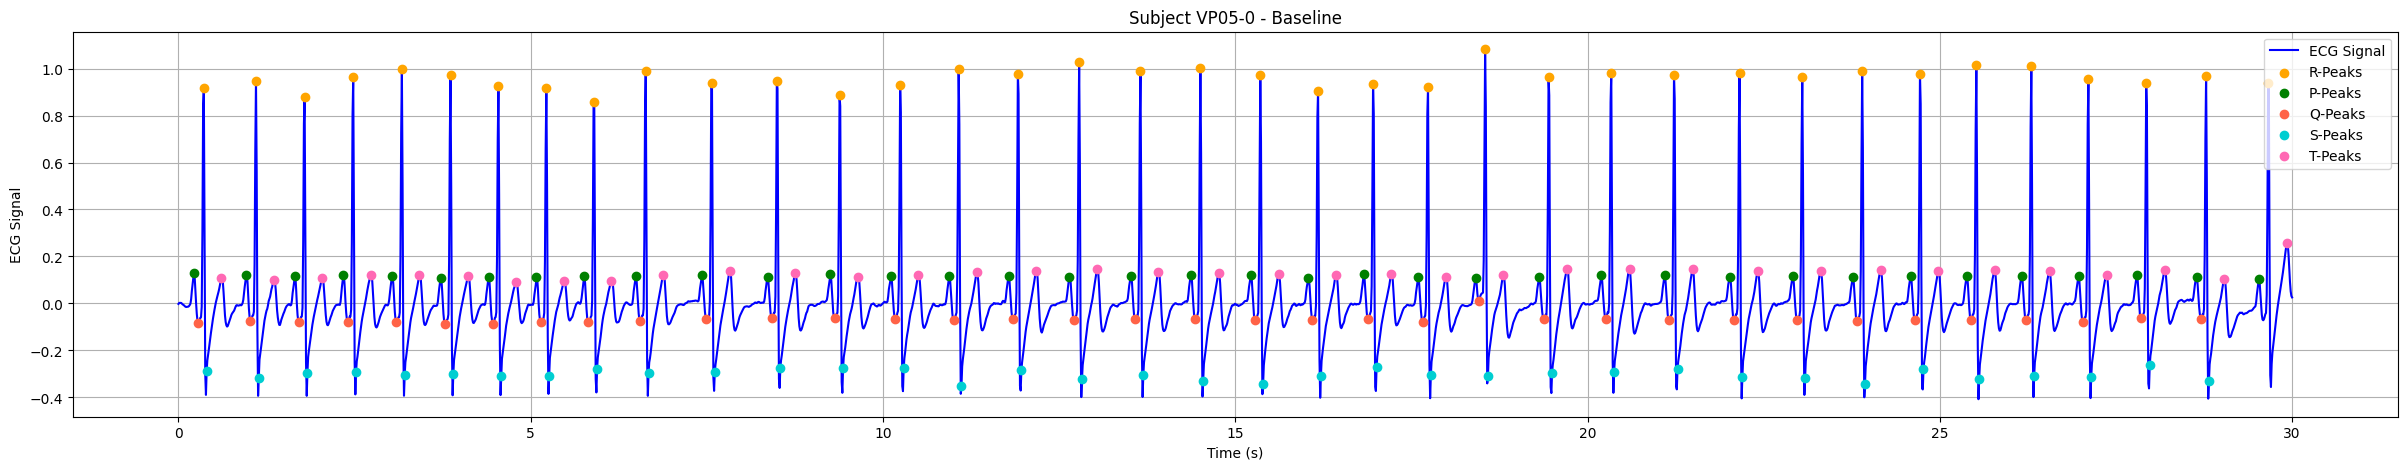

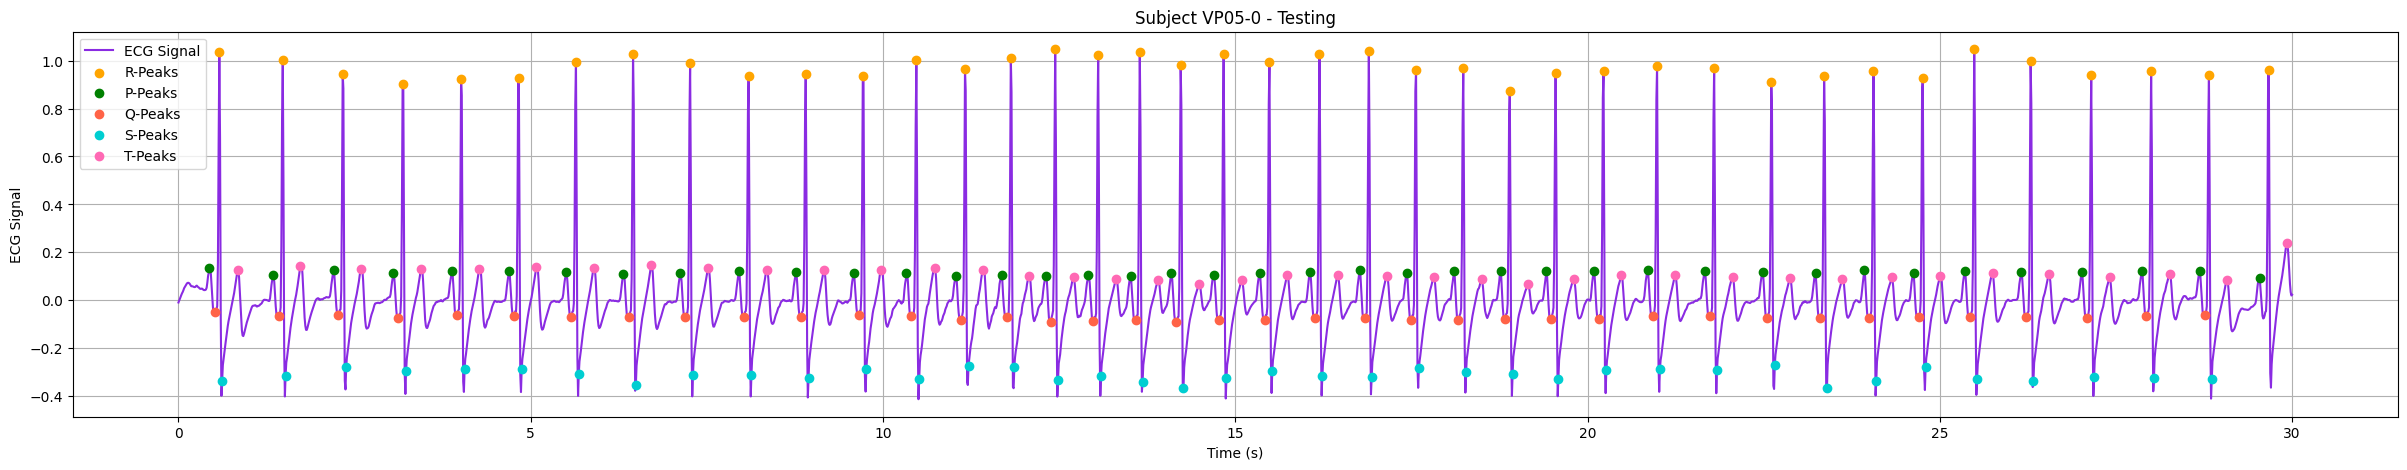

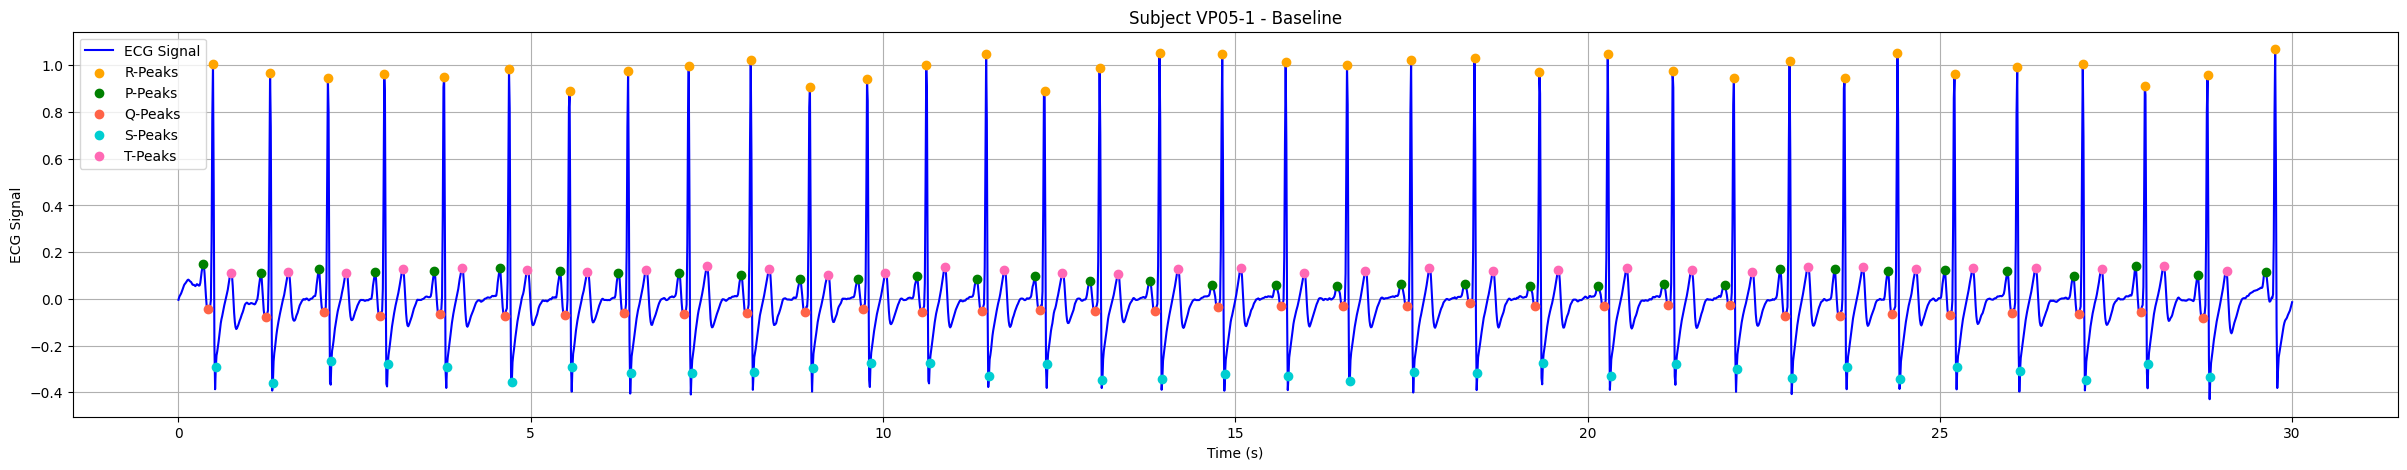

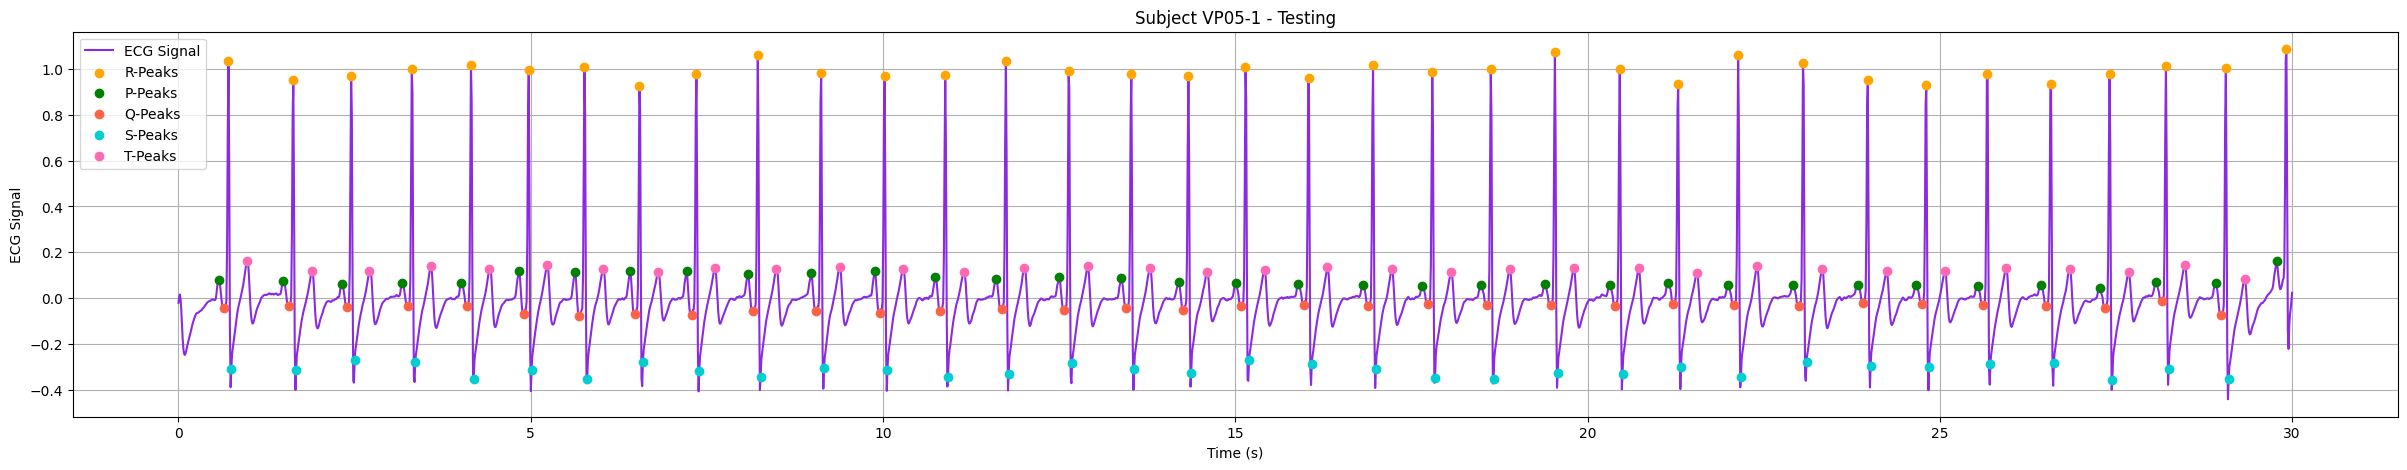

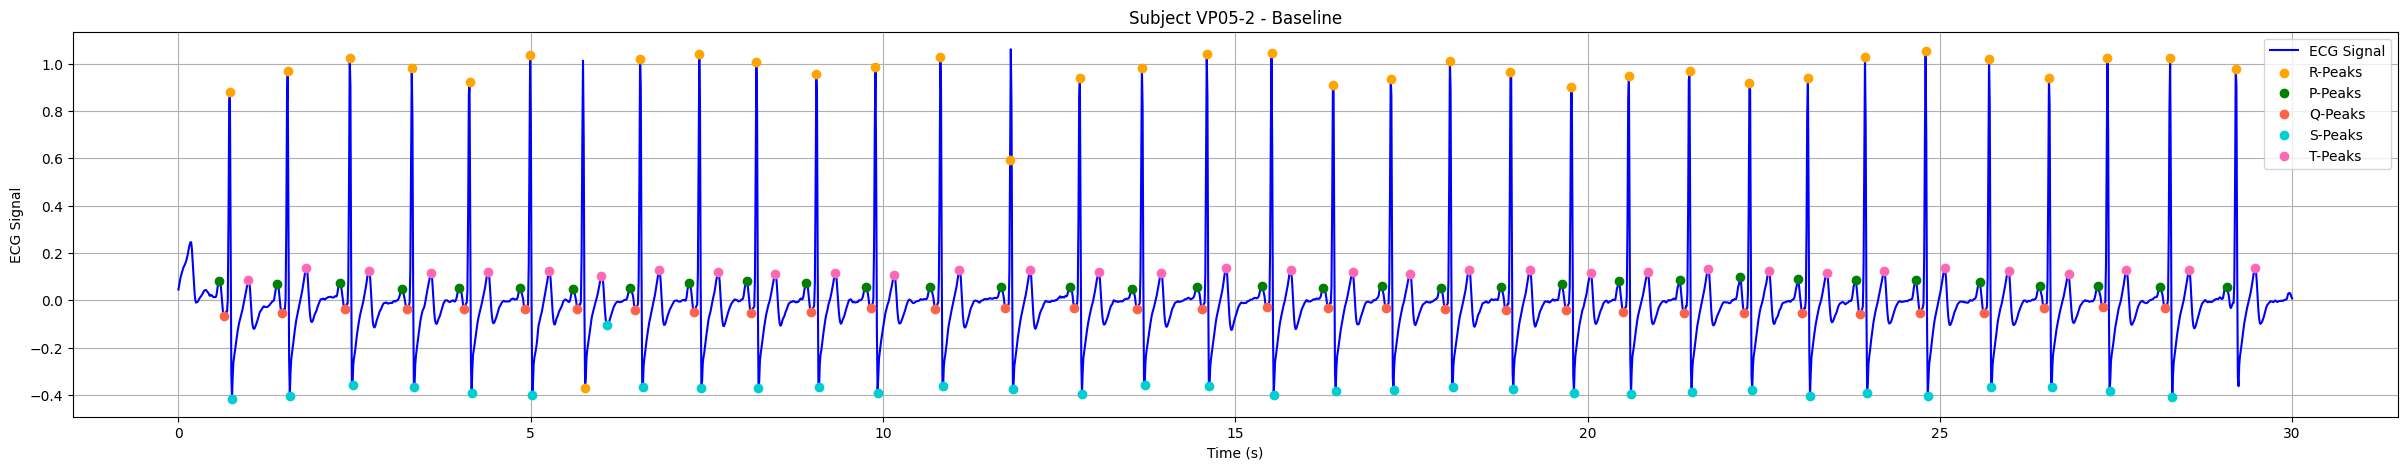

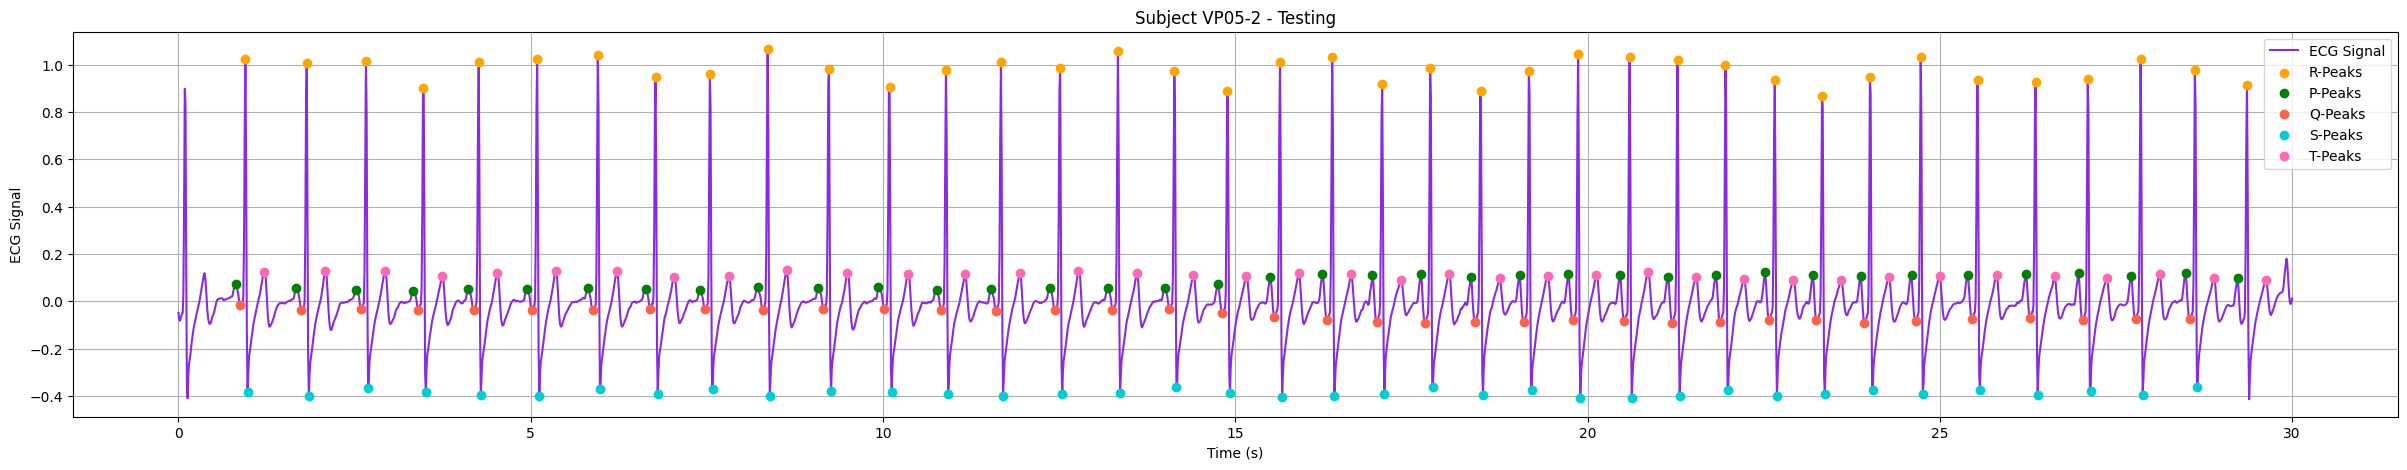

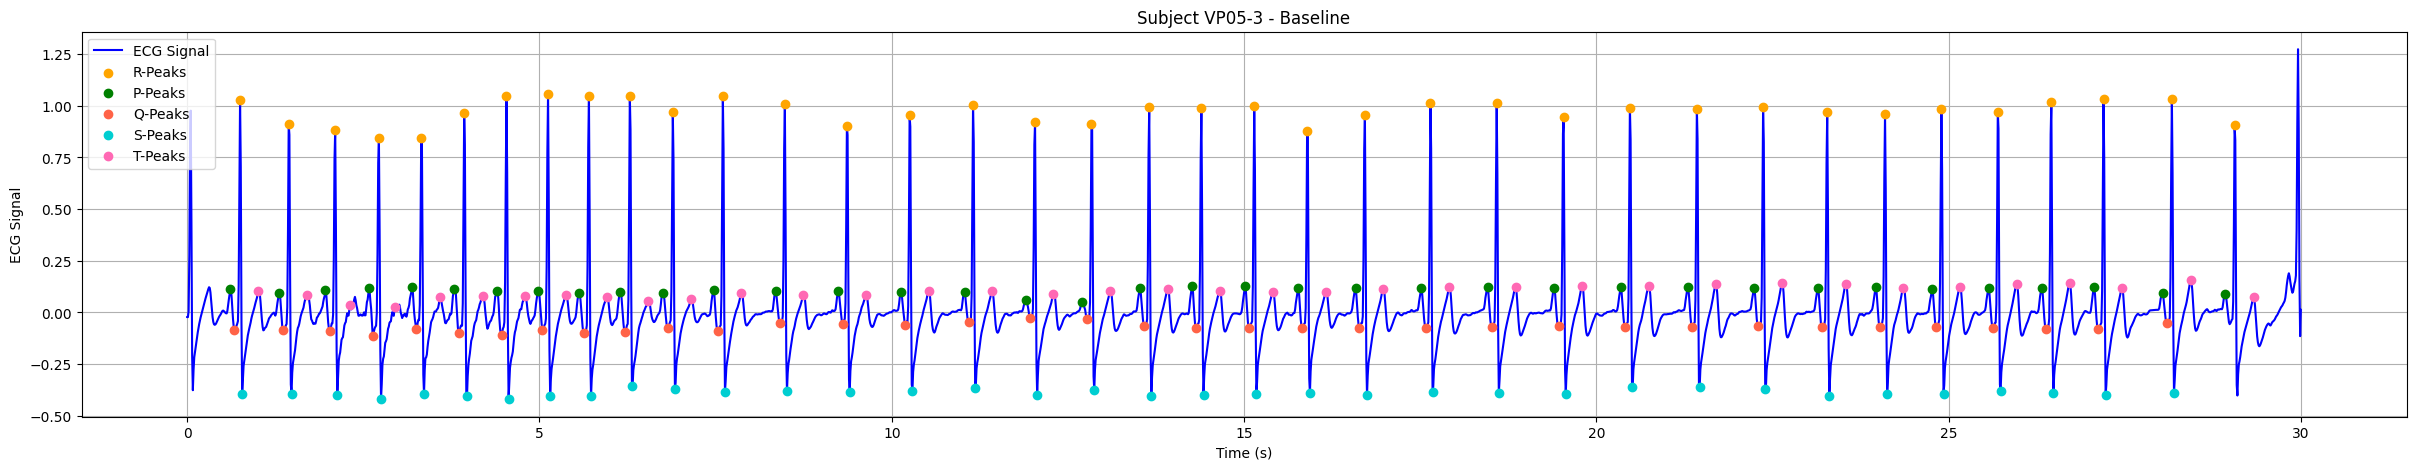

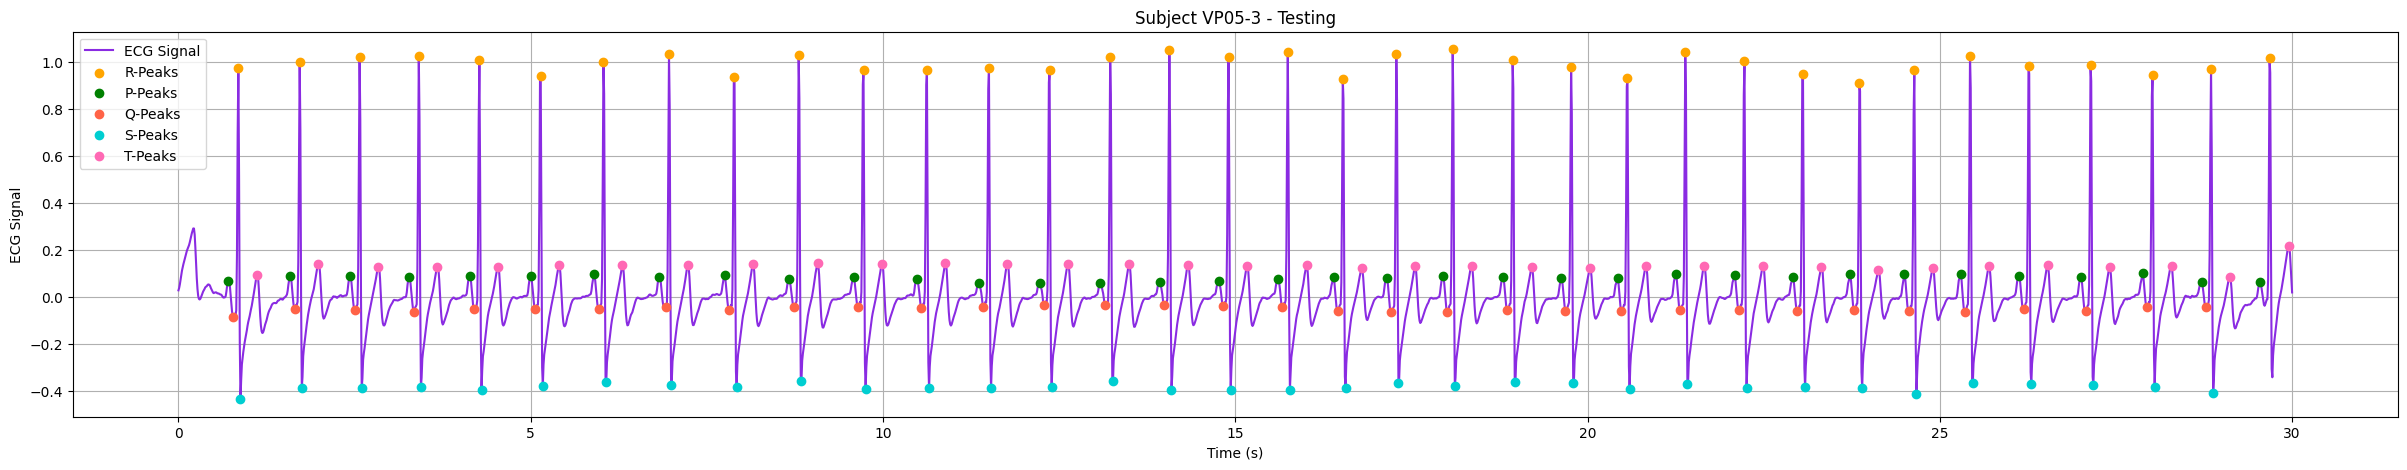

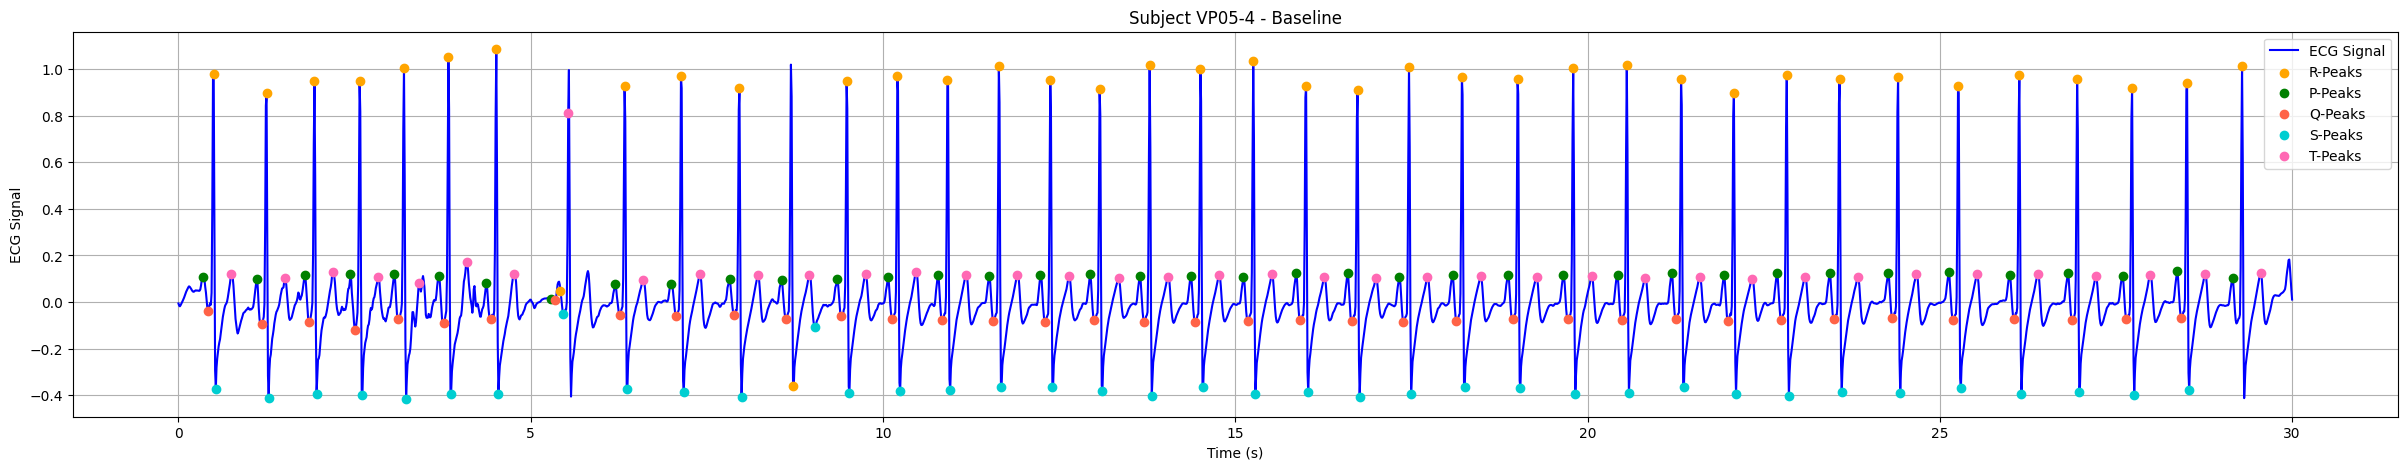

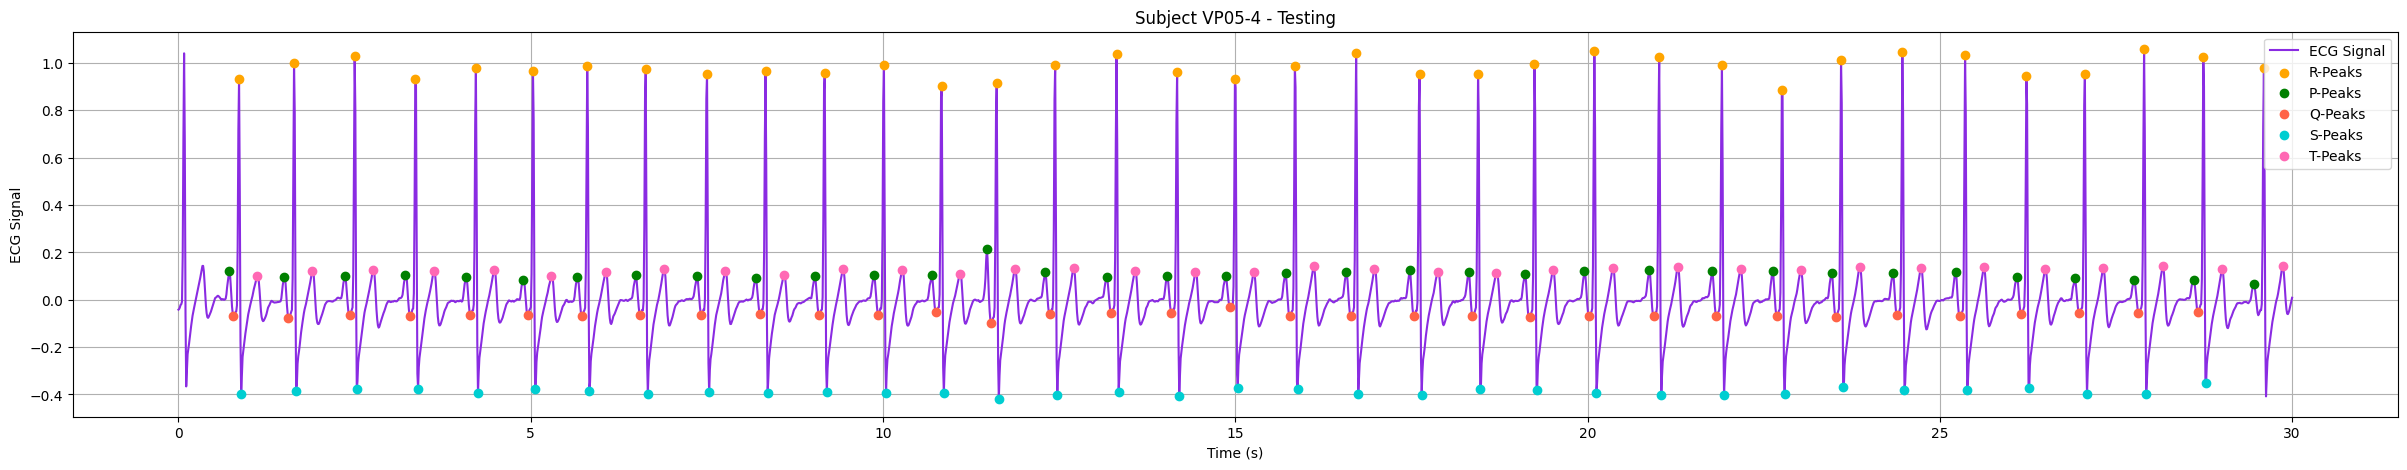

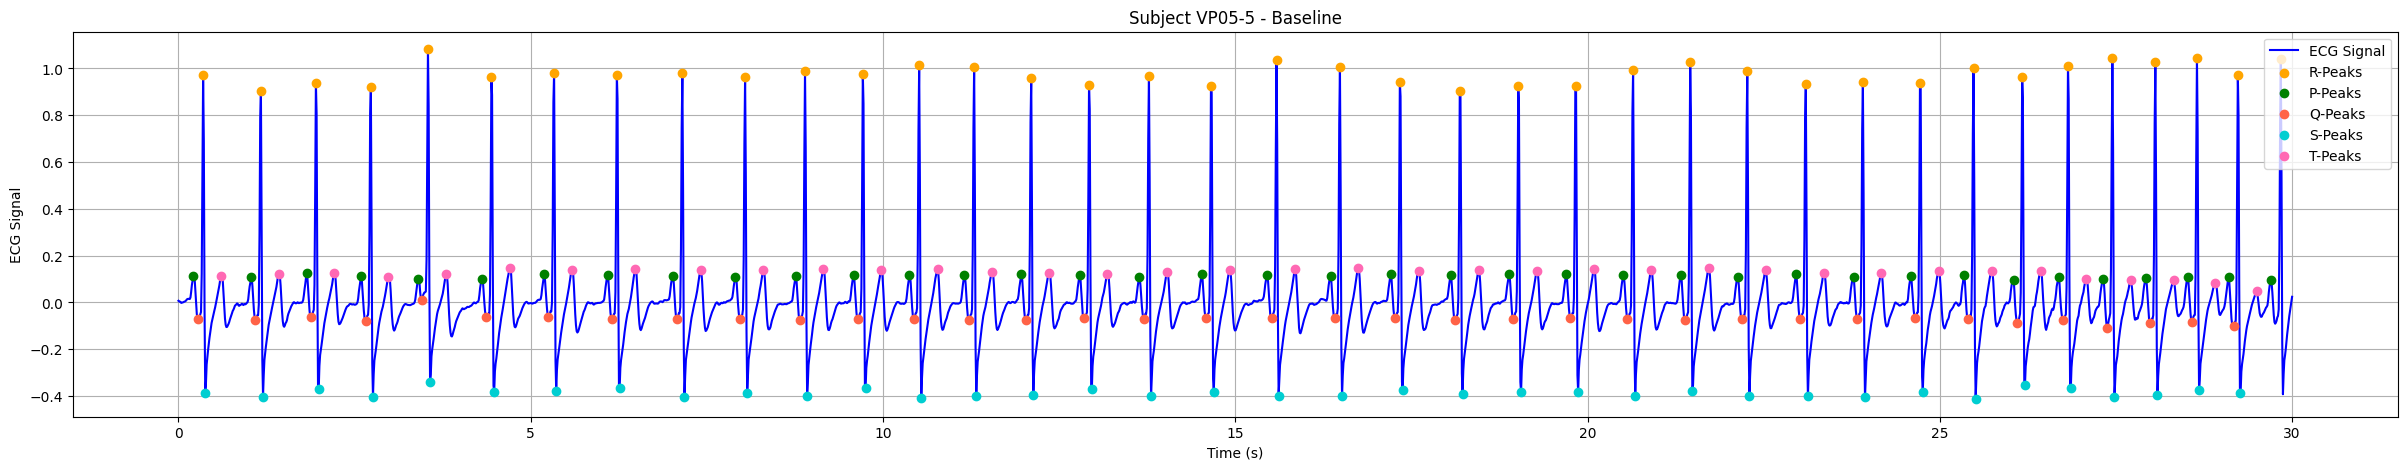

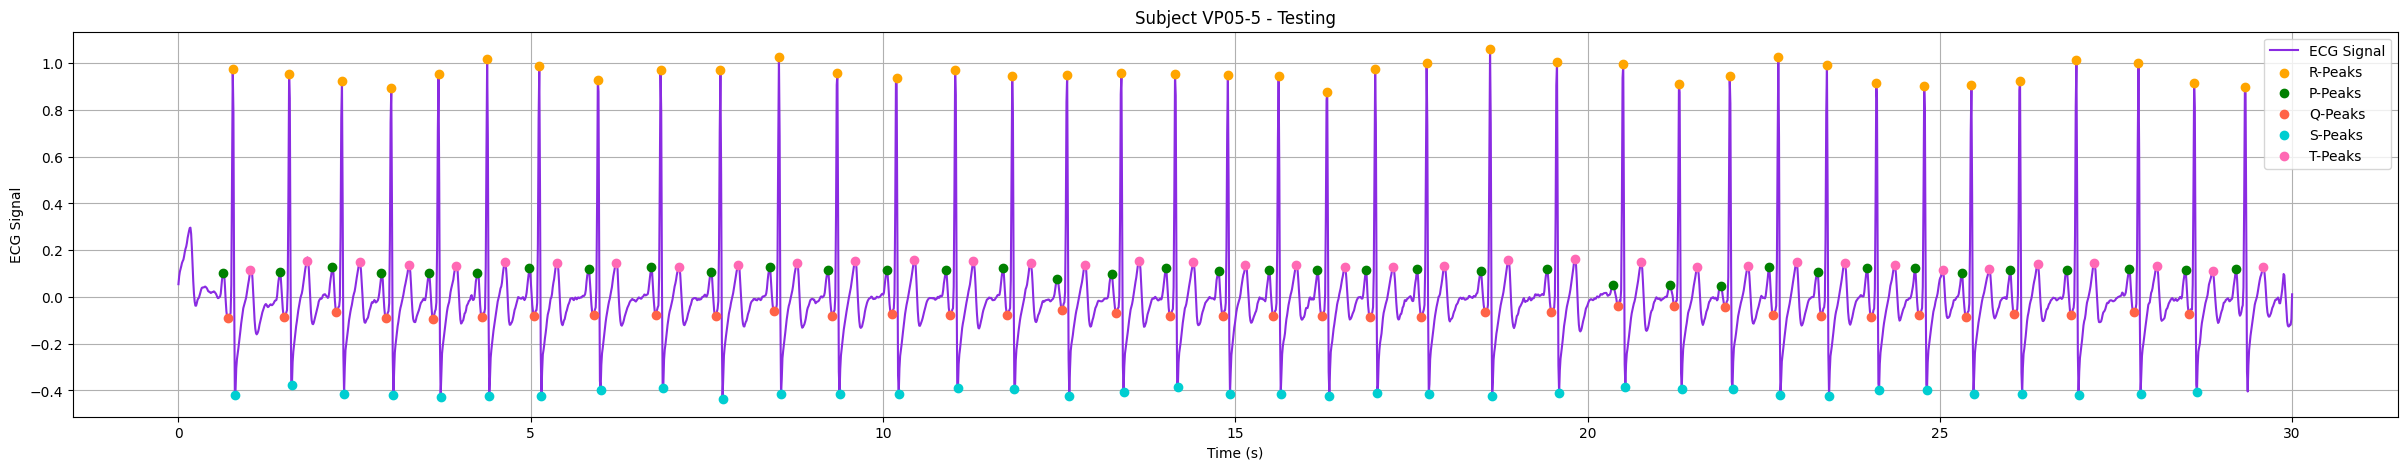

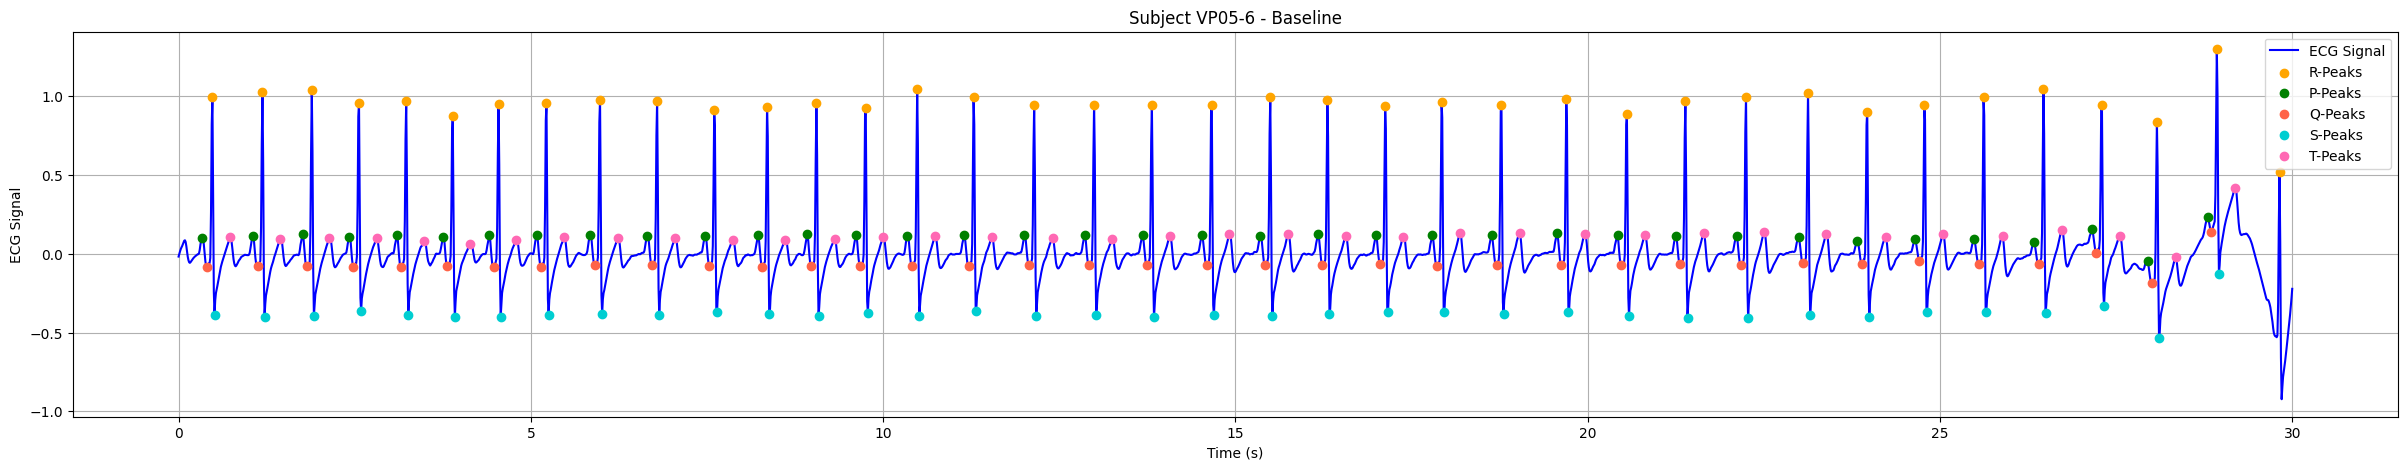

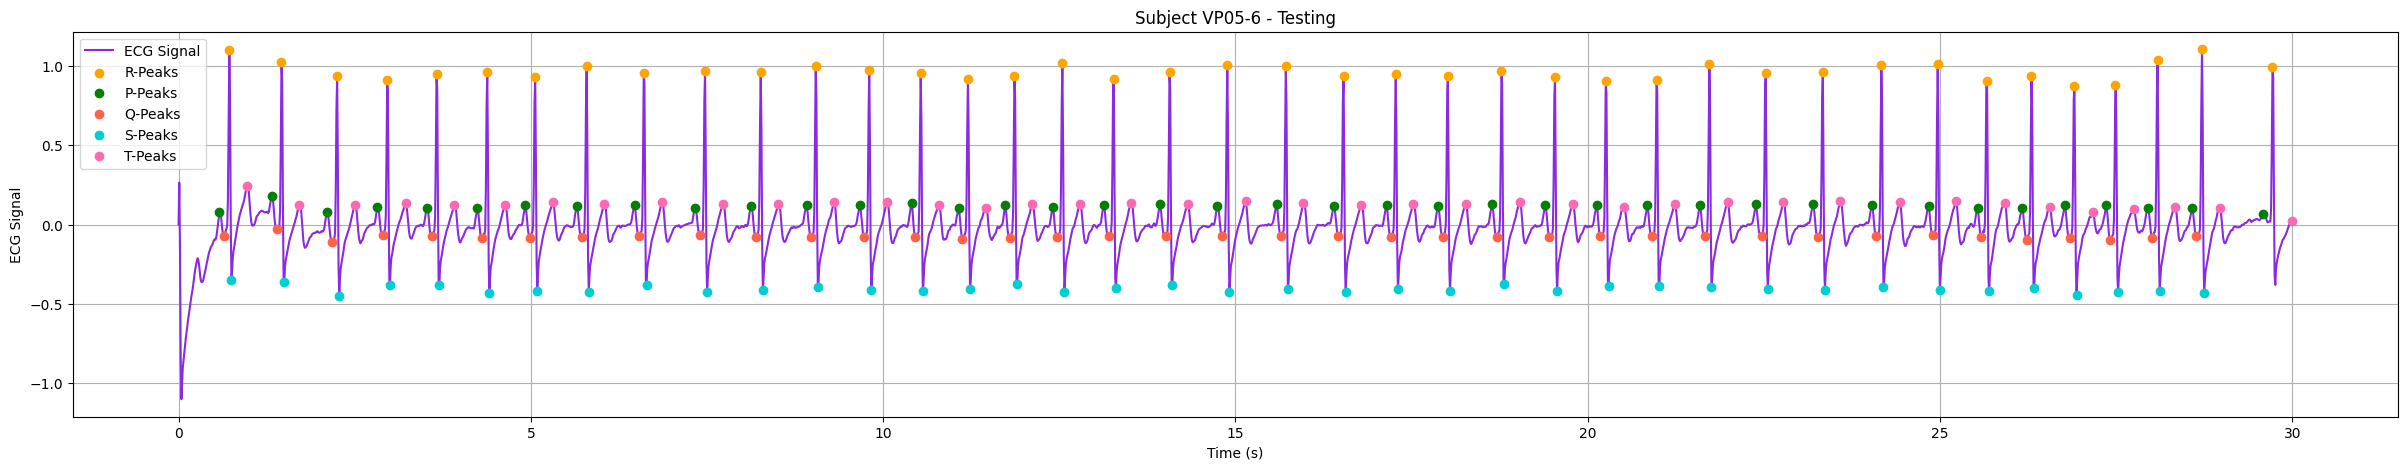

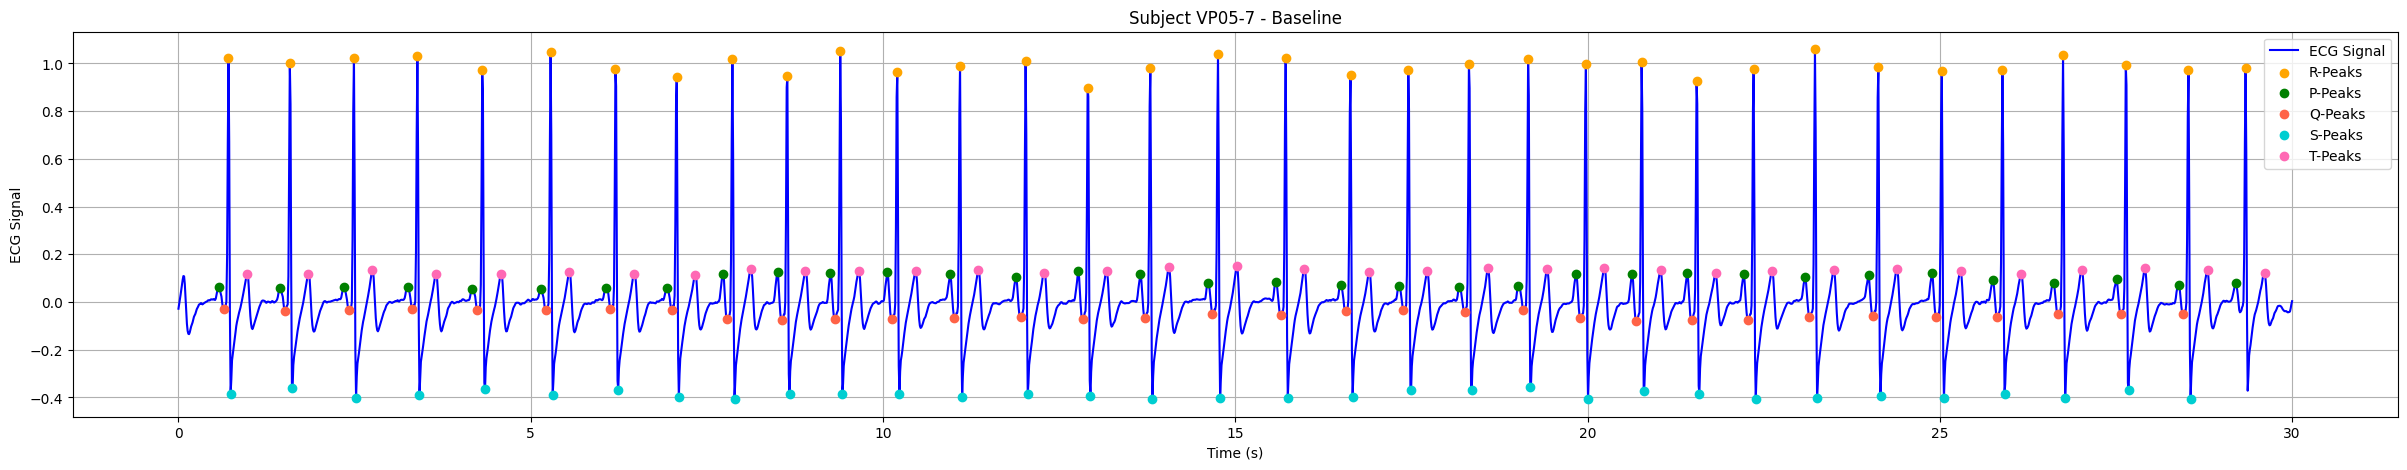

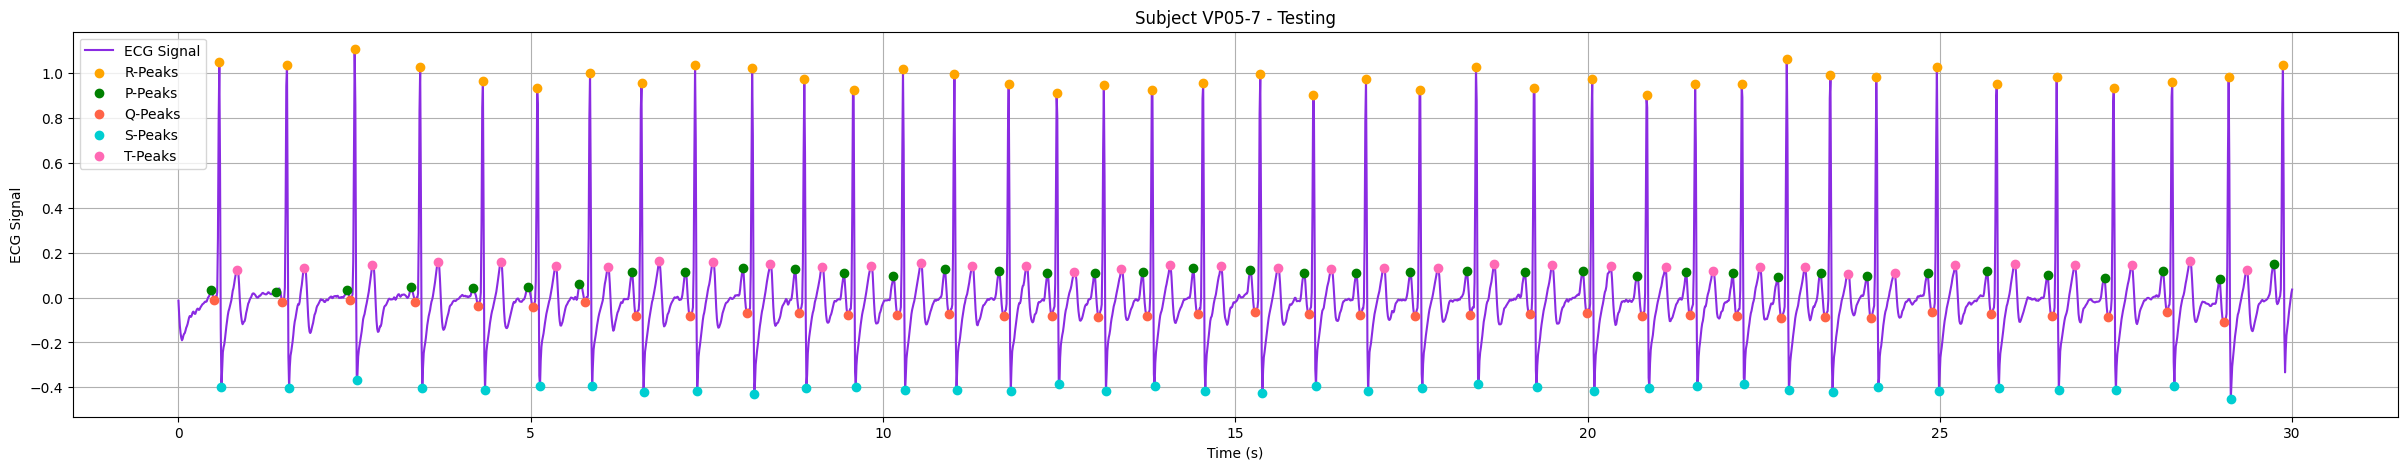

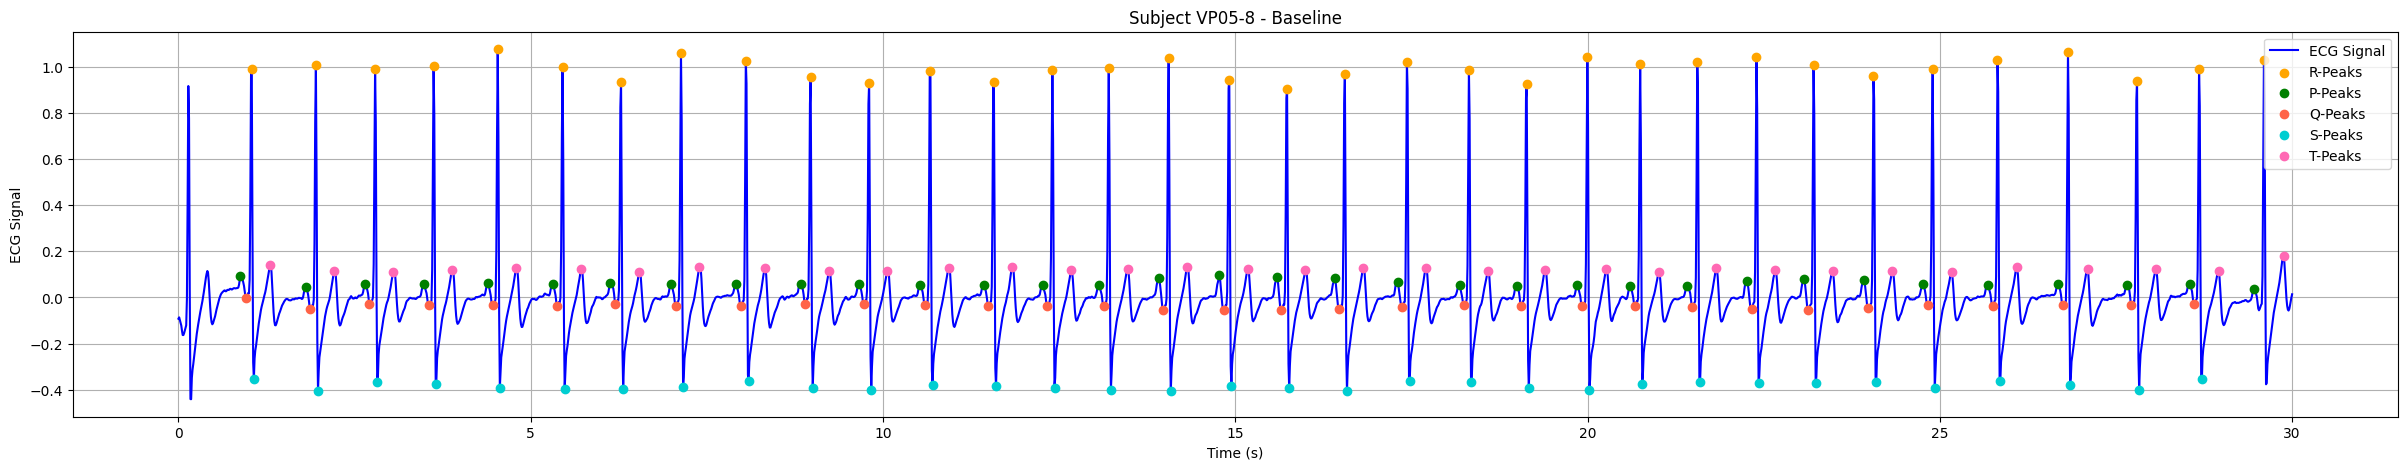

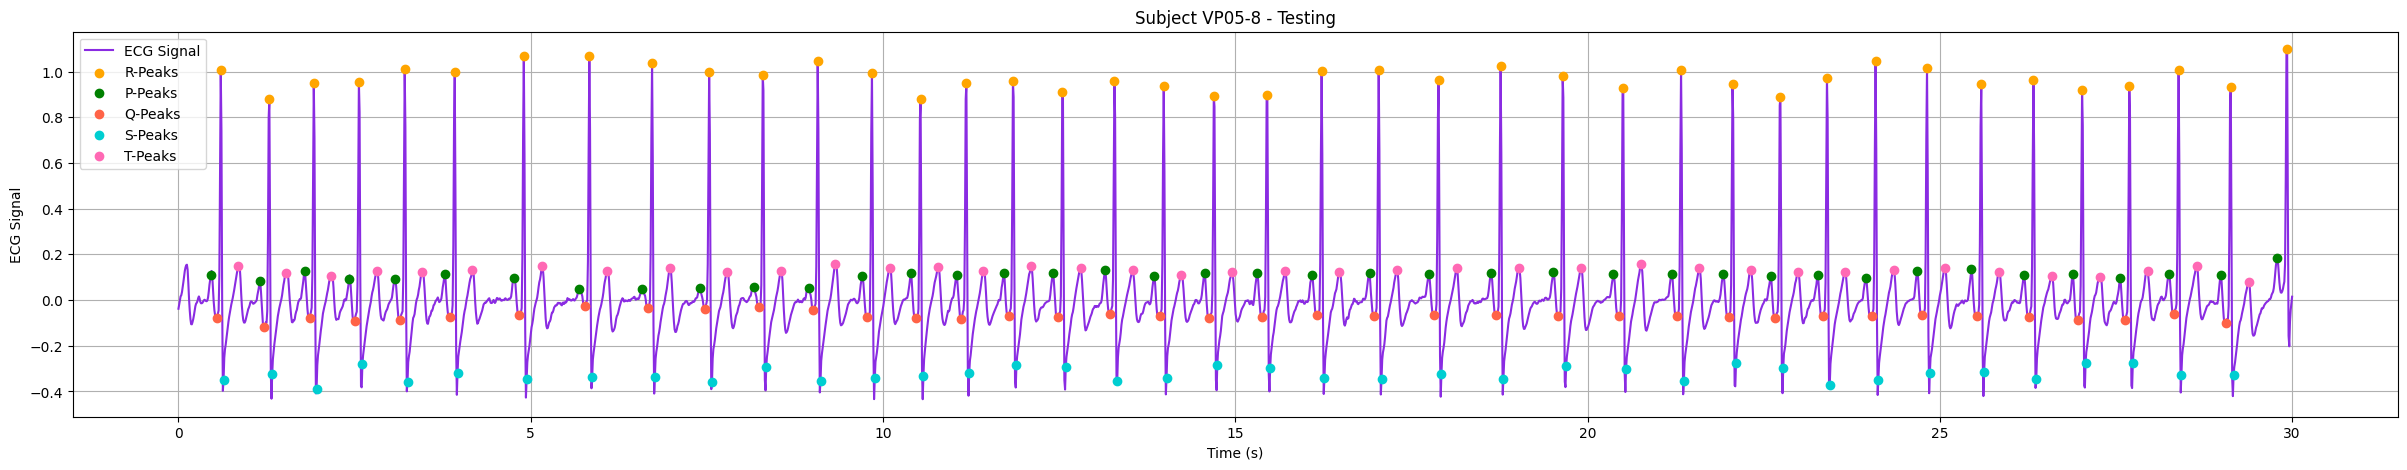

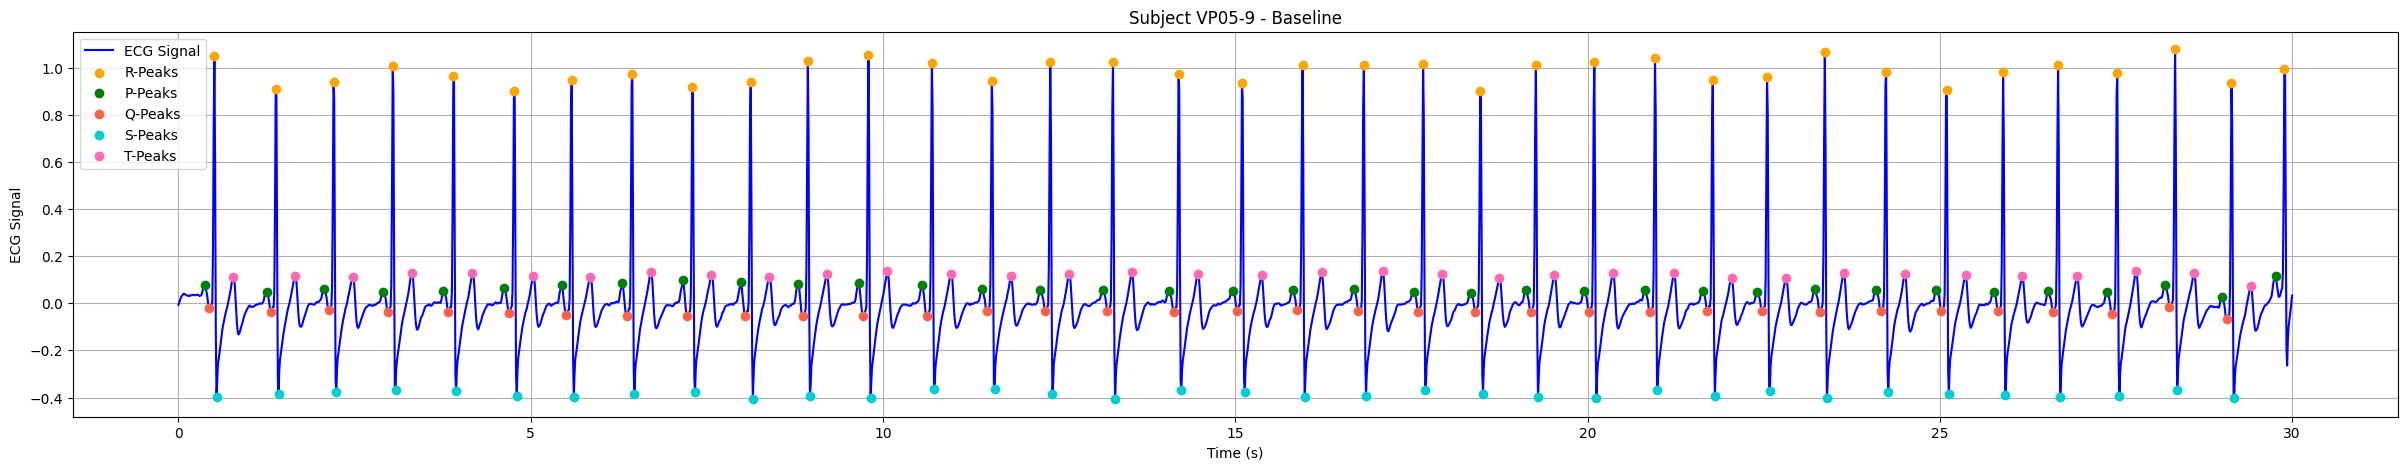

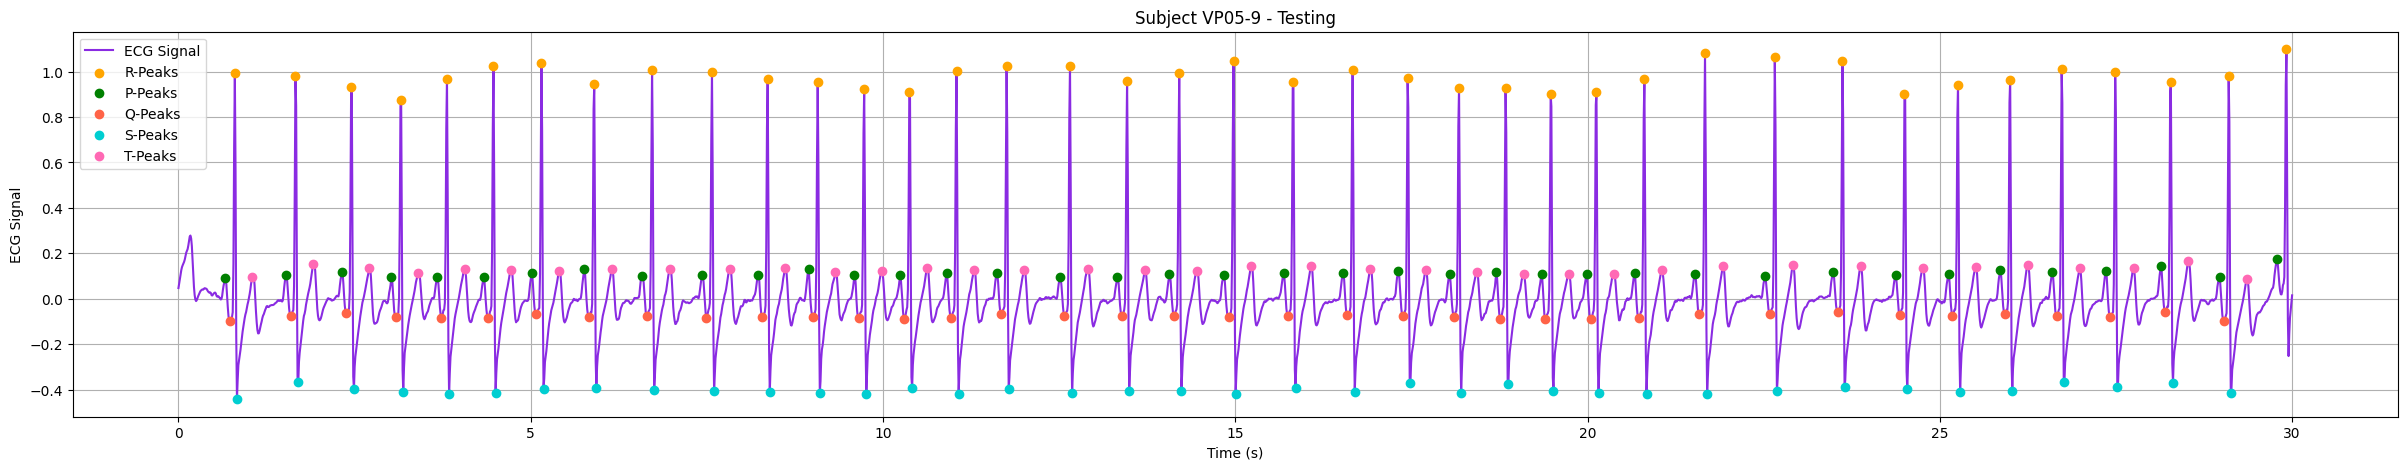

In [8]:
def graph_some_samples(data, end_num, start_num=0):
    subjects = data['subject'].unique()
    for subject in subjects[start_num:end_num]:
        subject_data = data[data.subject == subject]
        ecg1 = subject_data.ecg1.values
        ecg2 = subject_data.ecg2.values

        plot_ecg(ecg1, subject, "Baseline", "blue", neurokit_graph=False)
        plot_ecg(ecg2, subject, "Testing", "blueviolet", neurokit_graph=False)

graph_some_samples(data, 10, 0)

Histogram Graphing Function:
------

In [11]:
def graph_features(X, y):
    feature_names = [
        "BPM Change", "HRV Change", "HRSD Change", "QRS Change", "Amplitude Change", 
        "RMSSD Change", "Mean RR Change", "Mean PR Change", "PR SD Change", 
        "Mean ST Change", "NFD Mean Change", "NSD Mean Change"
    ]
    
    X = np.array(X)
    y = pd.Series(y, name='Label')
    
    unique_labels = y.unique()
    
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 12))
    axes = axes.flatten()
    
    for i in range(len(feature_names)):
        min_value = np.min(X[:, i])
        max_value = np.max(X[:, i])
        bins = np.linspace(min_value, max_value, 40) 

        for label in unique_labels:
            label_data = X[y == label, i]
            axes[i].hist(label_data, bins=bins, alpha=0.5, label=f'Label {label}', edgecolor='black')
        
        axes[i].set_title(feature_names[i])
        axes[i].set_xlabel("Value")
        axes[i].set_ylabel("Frequency")
        axes[i].legend()
    
    for j in range(len(feature_names), len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()


Histograms:
------

------------- Actual Change Histograms -------------


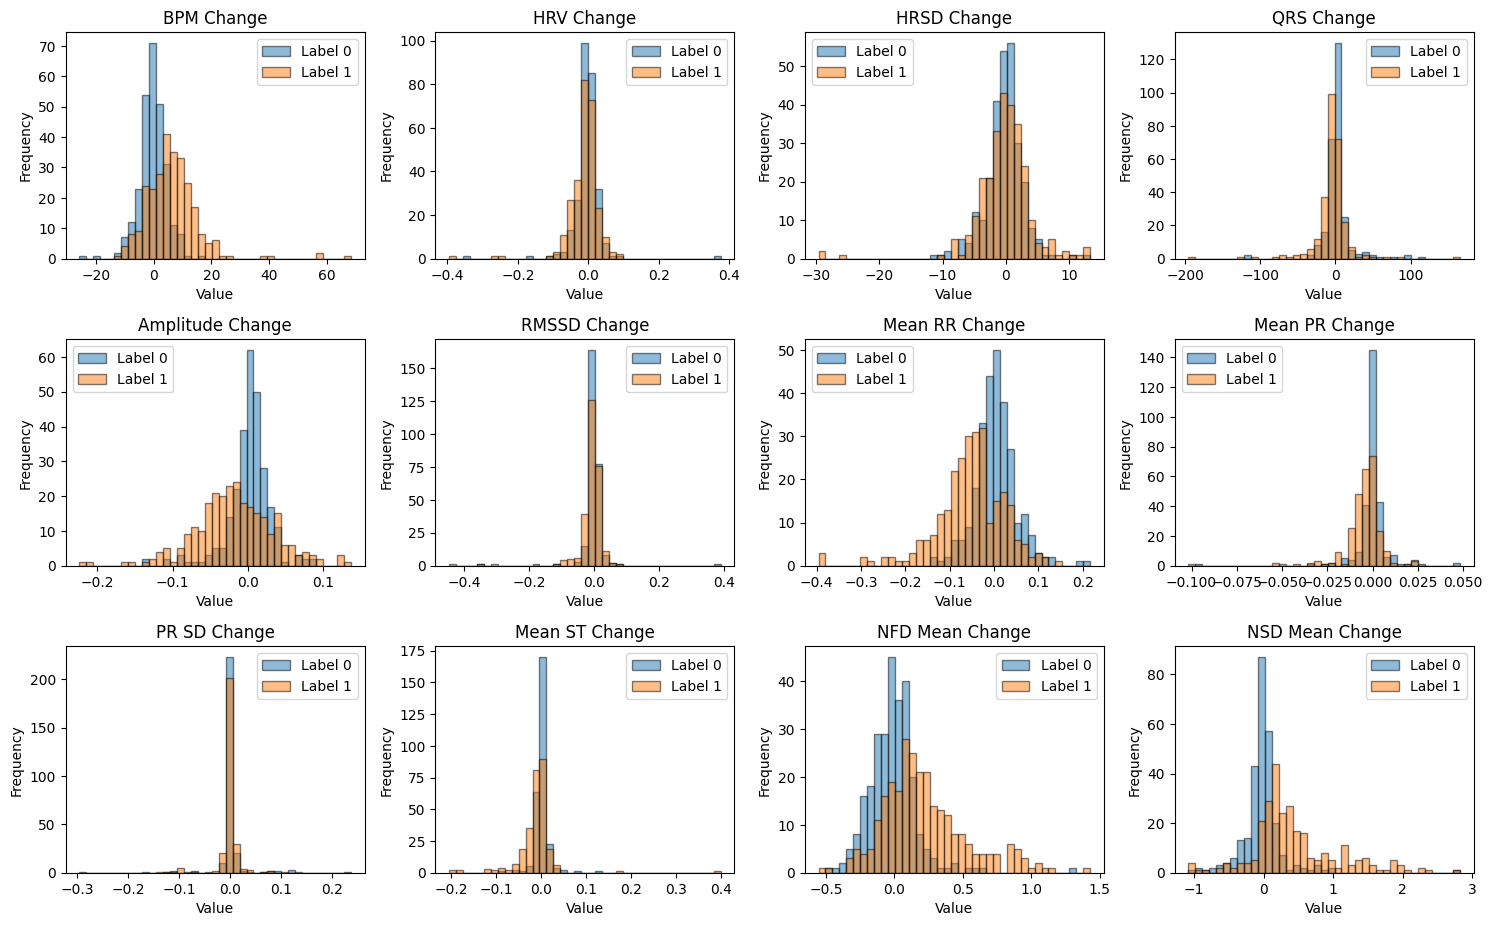

------------- Percent Change Histograms -------------


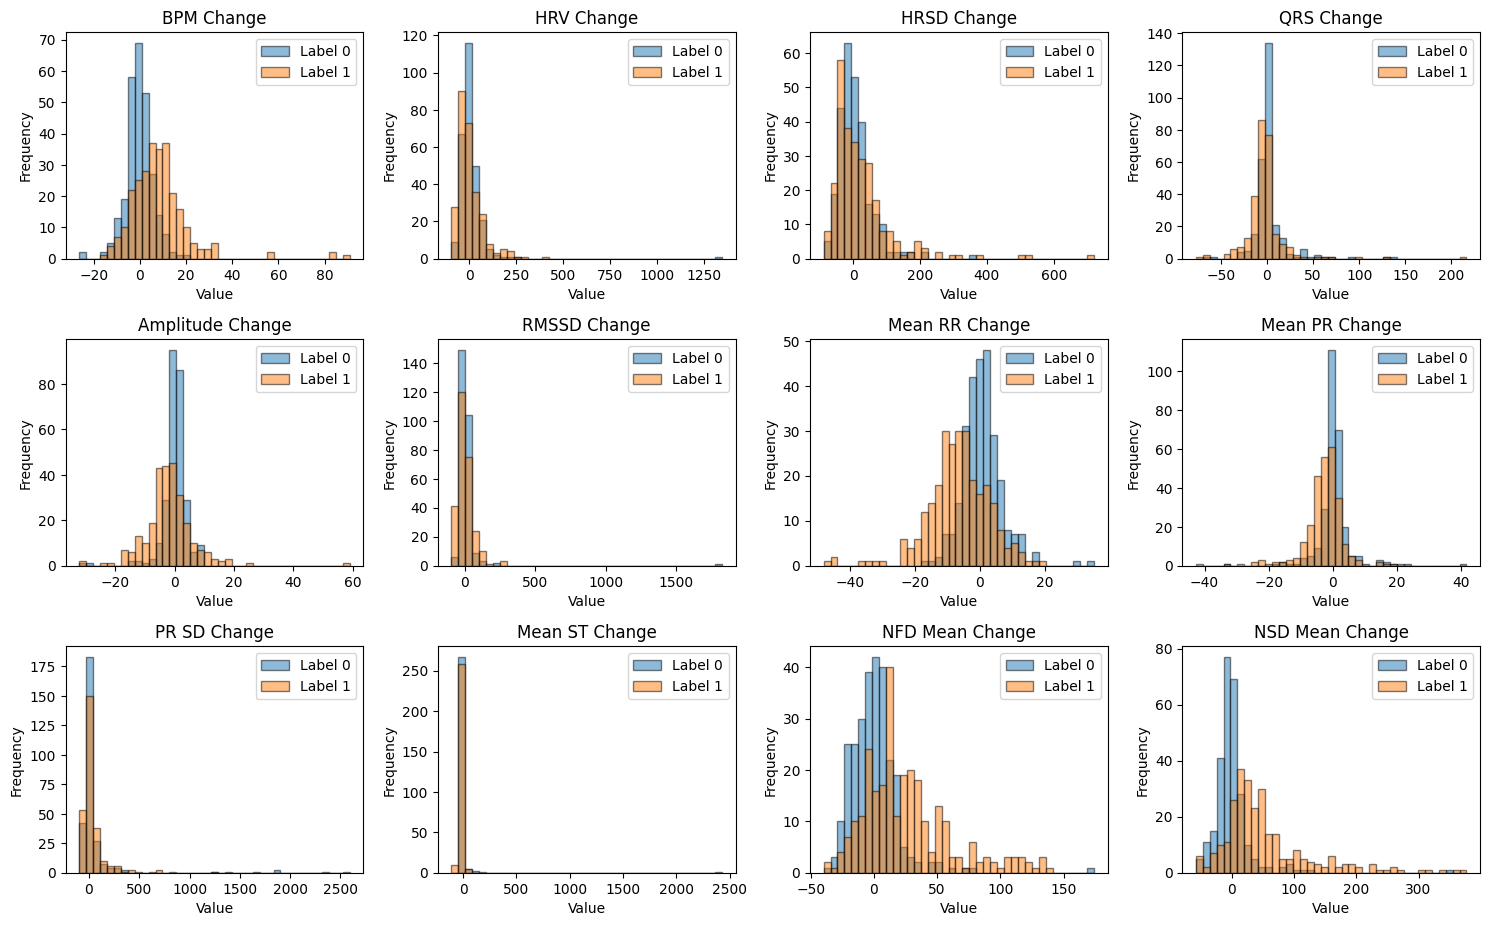

In [12]:
print("------------- Actual Change Histograms -------------")
graph_features(X, y)

print("------------- Percent Change Histograms -------------")
graph_features(X_percent, y_percent)

Testing Models:
------

In [141]:
datasets = {
    'X, y': (X, y),
    'X_percent, y_percent': (X_percent, y_percent)
}

scaler = StandardScaler()

models = {
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=5000),
        'params': {
            'C': [0.001, 0.01, 0.1, 1, 10, 100],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear', 'saga'],
            'random_state': [42]
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [None, 5, 10],
            'min_samples_split': [2, 5],
            'random_state': [42]
        }
    },
    'SVM': {
        'model': SVC(probability=True),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf']
        }
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7, 12],
            'weights': ['uniform', 'distance']
        }
    },
    'SGD': {
        'model': SGDClassifier(),
        'params': {
            'loss': ['hinge', 'log_loss'],
            'alpha': [0.0001, 0.001, 0.01],
            'random_state': [42, None]
        }
    }
}

for dataset_name, (X_data, y_data) in datasets.items():
    print(f"\n---------- Training with {dataset_name} ----------")

    X_train, X_test, y_train, y_test = train_test_split(
        X_data, y_data, test_size=0.2, stratify=y_data, random_state=42)

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    selector = SelectFromModel(RandomForestClassifier(n_estimators=100))
    X_selected = selector.fit_transform(X_train, y_train)

    selected_features = selector.get_support(indices=True)
    print(f"Selected feature indices: {selected_features}")

    results = []
    for name, config in models.items():
        if name == 'Random Forest':
            X_train_model = X_selected
            X_test_model = selector.transform(X_test)
        else:
            X_train_model, X_test_model = X_train, X_test

        grid = GridSearchCV(config['model'],
                            config['params'],
                            cv=StratifiedKFold(5),
                            scoring='accuracy',
                            n_jobs=-1)

        grid.fit(X_train_model, y_train)
        best_model = grid.best_estimator_

        best_model.fit(X_train_model, y_train)

        test_acc = best_model.score(X_test_model, y_test)
        train_acc = best_model.score(X_train_model, y_train)

        results.append({
            'model': name,
            'best_params': grid.best_params_,
            'train_accuracy': train_acc,
            'test_accuracy': test_acc
        })

        print(f"Best {name} Model: {grid.best_params_}")
    
    results_df = pd.DataFrame(results)
    print(results_df)


---------- Training with X_percent, y_percent ----------
Selected feature indices: [ 0  6  7 10 11]
Best Logistic Regression Model: {'C': 0.1, 'penalty': 'l1', 'random_state': 42, 'solver': 'saga'}
Best Random Forest Model: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100, 'random_state': 42}
Best SVM Model: {'C': 1, 'kernel': 'rbf'}
Best KNN Model: {'n_neighbors': 7, 'weights': 'distance'}
Best SGD Model: {'alpha': 0.001, 'loss': 'hinge', 'random_state': 42}
                 model                                        best_params  \
0  Logistic Regression  {'C': 0.1, 'penalty': 'l1', 'random_state': 42...   
1        Random Forest  {'max_depth': 10, 'min_samples_split': 5, 'n_e...   
2                  SVM                          {'C': 1, 'kernel': 'rbf'}   
3                  KNN          {'n_neighbors': 7, 'weights': 'distance'}   
4                  SGD  {'alpha': 0.001, 'loss': 'hinge', 'random_stat...   

   train_accuracy  test_accuracy  
0        0.799087       

Best Logistical Regression:
------

Train Accuracy: 0.799087
Test Accuracy: 0.845455
Cross-Validation Scores: [0.81818182 0.77272727 0.81818182 0.86363636 0.72727273 0.68181818
 0.77272727 0.72727273 0.77272727 0.72727273 0.86363636 0.72727273
 0.68181818 0.86363636 0.86363636 0.81818182 0.90909091 0.63636364
 0.80952381 0.76190476]
Mean CV Accuracy: 0.780844


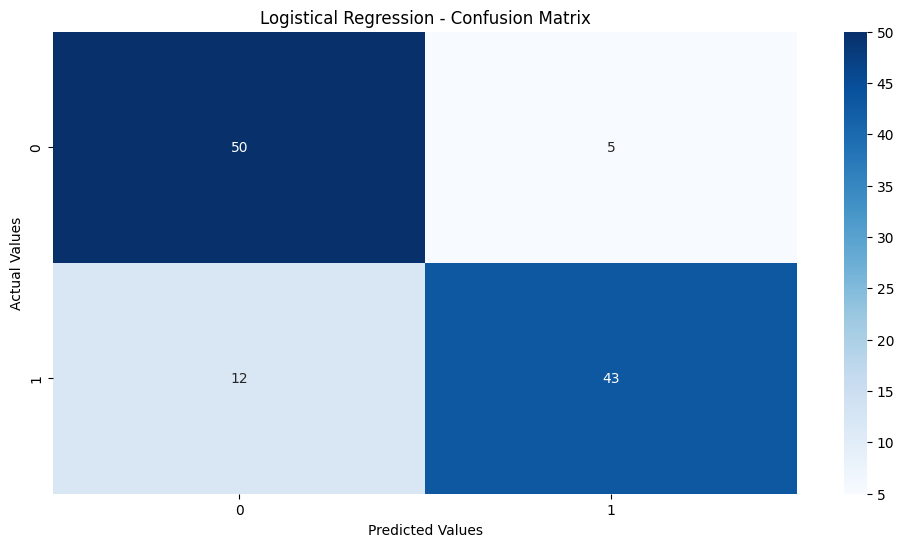

In [142]:
chosen_X = X_percent 
chosen_y = y_percent
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(chosen_X, chosen_y, test_size=0.2, stratify=chosen_y,random_state=42)

X_train_lr = scaler.fit_transform(X_train_lr)
X_test_lr = scaler.transform(X_test_lr)

model_lr = LogisticRegression(max_iter=5000, C=0.1, penalty='l1', solver='saga', random_state=42)

model_lr.fit(X_train_lr, y_train_lr)

y_pred_lr = model_lr.predict(X_test_lr)

test_acc_lr = model_lr.score(X_test_lr, y_test_lr)
train_acc_lr = model_lr.score(X_train_lr, y_train_lr)

print(f'Train Accuracy: {train_acc_lr:.6f}\nTest Accuracy: {test_acc_lr:.6f}')

cv_scores = cross_val_score(model_lr, X_train_lr, y_train_lr, cv=20)
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {np.mean(cv_scores):.6f}')

cm=confusion_matrix(y_test_lr,y_pred_lr)
plt.figure(figsize=(12,6))
plt.title("Logistical Regression - Confusion Matrix")
sns.heatmap(cm, annot=True,fmt='d', cmap='Blues')
plt.ylabel("Actual Values")
plt.xlabel("Predicted Values")
plt.show()

Best Random Forest:
------

Selected feature indices: [ 0  6  7 10 11]
Train Accuracy: 1.000000
Test Accuracy: 0.818182
Cross-Validation Scores: [0.86363636 0.77272727 0.86363636 0.86363636 0.77272727 0.72727273
 0.72727273 0.72727273 0.86363636 0.86363636 0.90909091 0.72727273
 0.86363636 0.77272727 0.86363636 0.81818182 0.77272727 0.68181818
 0.76190476 0.71428571]
Mean CV Accuracy: 0.796537


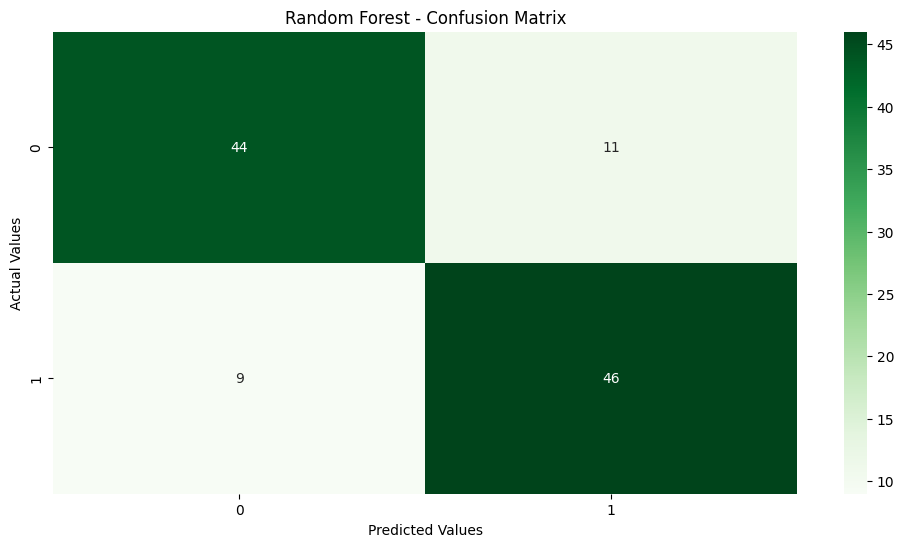

In [143]:
chosen_X = X_percent 
chosen_y = y_percent
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(chosen_X, chosen_y, test_size=0.2, stratify=chosen_y,random_state=42)

selector = SelectFromModel(RandomForestClassifier(n_estimators=100))
X_selected = selector.fit_transform(X_train_rf, y_train_rf)

selected_features = selector.get_support(indices=True)
print(f"Selected feature indices: {selected_features}")

X_train_selected_rf = X_selected
X_test_selected_rf = selector.transform(X_test_rf)

model_rf = RandomForestClassifier(max_depth=None, min_samples_split=2, n_estimators=200, random_state=42)

model_rf.fit(X_train_selected_rf, y_train_rf)

y_pred_rf = model_rf.predict(X_test_selected_rf)

train_acc_rf = model_rf.score(X_train_selected_rf, y_train_rf)
test_acc_rf = model_rf.score(X_test_selected_rf, y_test_rf)

print(f'Train Accuracy: {train_acc_rf:.6f}\nTest Accuracy: {test_acc_rf:.6f}')

cv_scores = cross_val_score(model_rf, X_train_selected_rf, y_train_rf, cv=20)
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {np.mean(cv_scores):.6f}')

cm_rf = confusion_matrix(y_test_rf, y_pred_rf)
plt.figure(figsize=(12,6))
plt.title("Random Forest - Confusion Matrix")
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens')
plt.ylabel("Actual Values")
plt.xlabel("Predicted Values")
plt.show()


Best SVC:
------

Train Accuracy: 0.844749
Test Accuracy: 0.890909
Cross-Validation Scores: [0.86363636 0.81818182 0.90909091 0.90909091 0.77272727 0.81818182
 0.72727273 0.86363636 0.72727273 0.81818182 0.86363636 0.63636364
 0.77272727 0.81818182 0.81818182 0.90909091 0.95454545 0.63636364
 0.71428571 0.80952381]
Mean CV Accuracy: 0.808009


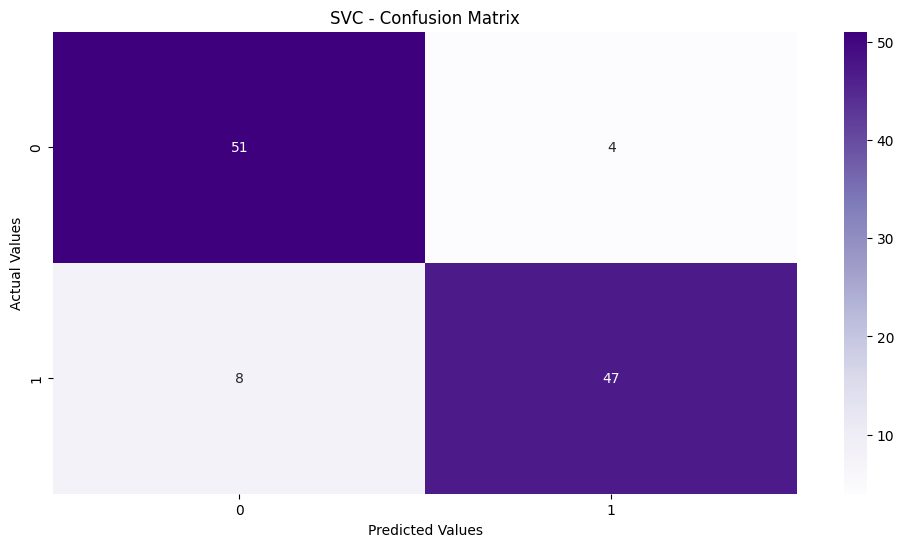

In [56]:
chosen_X = X_percent
chosen_y = y_percent
X_train_svc, X_test_svc, y_train_svc, y_test_svc = train_test_split(chosen_X, chosen_y, test_size=0.2, stratify=chosen_y,random_state=42)

X_train_svc = scaler.fit_transform(X_train_svc)
X_test_svc = scaler.transform(X_test_svc)

model_svc = SVC(C=1, kernel='rbf')
model_svc.fit(X_train_svc, y_train_svc)

y_pred_svc = model_svc.predict(X_test_svc)

train_acc_svc = model_svc.score(X_train_svc, y_train_svc)
test_acc_svc = model_svc.score(X_test_svc, y_test_svc)

print(f'Train Accuracy: {train_acc_svc:.6f}\nTest Accuracy: {test_acc_svc:.6f}')

cv_scores = cross_val_score(model_svc, X_train_svc, y_train_svc, cv=20)
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {np.mean(cv_scores):.6f}')

cm_svc = confusion_matrix(y_test_svc, y_pred_svc)
plt.figure(figsize=(12,6))
plt.title("SVC - Confusion Matrix")
sns.heatmap(cm_svc, annot=True, fmt='d', cmap='Purples')
plt.ylabel("Actual Values")
plt.xlabel("Predicted Values")
plt.show()

Best KNN:
------

Train Accuracy: 1.000000
Test Accuracy: 0.945455
Cross-Validation Scores: [0.86363636 0.86363636 0.86363636 0.90909091 0.77272727 0.81818182
 0.72727273 0.77272727 0.72727273 0.81818182 0.77272727 0.68181818
 0.72727273 0.77272727 0.86363636 0.86363636 0.86363636 0.63636364
 0.66666667 0.71428571]
Mean CV Accuracy: 0.784957


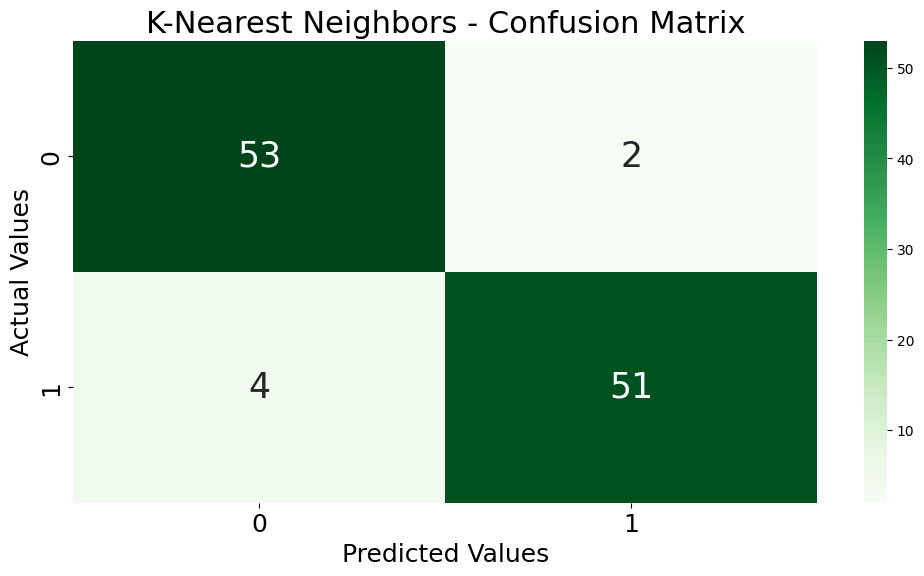

In [118]:
chosen_X = X_percent
chosen_y = y_percent
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(chosen_X, chosen_y, test_size=0.2, stratify=chosen_y,random_state=42)

X_train_knn = scaler.fit_transform(X_train_knn)
X_test_knn = scaler.transform(X_test_knn)

model_knn = KNeighborsClassifier(n_neighbors=12, weights='distance')
model_knn.fit(X_train_knn, y_train_knn)

y_pred_knn = model_knn.predict(X_test_knn)

test_acc_knn = model_knn.score(X_test_knn, y_test_knn)
train_acc_knn = model_knn.score(X_train_knn, y_train_knn)

print(f'Train Accuracy: {train_acc_knn:.6f}\nTest Accuracy: {test_acc_knn:.6f}')

cv_scores = cross_val_score(model_knn, X_train_knn, y_train_knn, cv=20)
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {np.mean(cv_scores):.6f}')

cm = confusion_matrix(y_test_knn, y_pred_knn)
plt.figure(figsize=(12,6))
plt.title("K-Nearest Neighbors - Confusion Matrix",fontsize=22)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',annot_kws={"size": 25})
plt.ylabel("Actual Values",fontsize=18)
plt.xlabel("Predicted Values",fontsize=18)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()


Best SGD:
------

Train Accuracy: 0.803653
Test Accuracy: 0.890909
Cross-Validation Scores: [0.81818182 0.77272727 0.86363636 0.90909091 0.77272727 0.77272727
 0.77272727 0.81818182 0.68181818 0.86363636 0.77272727 0.72727273
 0.68181818 0.72727273 0.81818182 0.86363636 0.90909091 0.59090909
 0.80952381 0.85714286]
Mean CV Accuracy: 0.790152


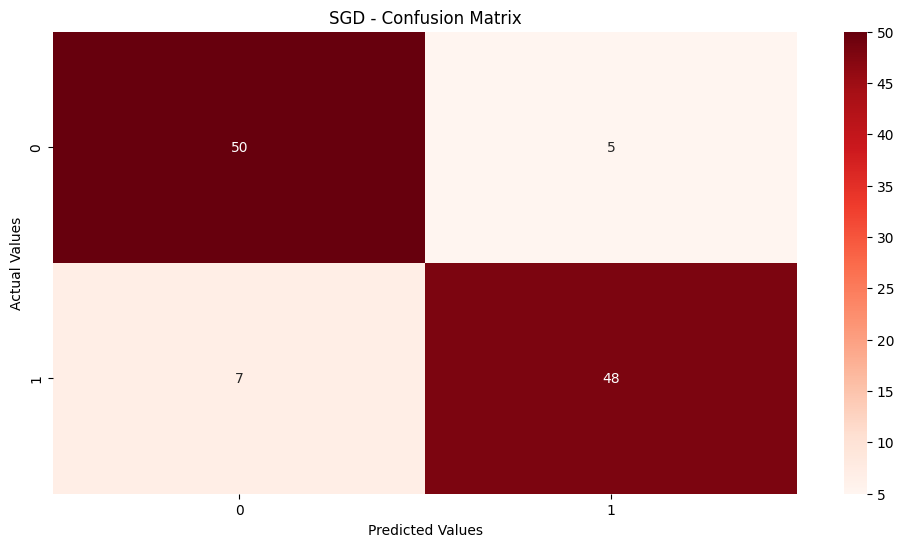

In [144]:
chosen_X = X_percent 
chosen_y = y_percent
X_train_sgd, X_test_sgd, y_train_sgd, y_test_sgd = train_test_split(chosen_X, chosen_y, test_size=0.2, stratify=chosen_y,random_state=42)

X_train_sgd = scaler.fit_transform(X_train_sgd)
X_test_sgd = scaler.transform(X_test_sgd)

model_sgd = SGDClassifier(alpha=0.01, loss='log_loss')
model_sgd.fit(X_train_sgd, y_train_sgd)

y_pred_sgd = model_sgd.predict(X_test_sgd)

train_acc_sgd = model_sgd.score(X_train_sgd, y_train_sgd)
test_acc_sgd = model_sgd.score(X_test_sgd, y_test_sgd)

print(f'Train Accuracy: {train_acc_sgd:.6f}\nTest Accuracy: {test_acc_sgd:.6f}')

cv_scores = cross_val_score(model_sgd, X_train_sgd, y_train_sgd, cv=20)
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {np.mean(cv_scores):.6f}')

cm_sgd = confusion_matrix(y_test_sgd, y_pred_sgd)
plt.figure(figsize=(12,6))
plt.title("SGD - Confusion Matrix")
sns.heatmap(cm_sgd, annot=True, fmt='d', cmap='Reds')
plt.ylabel("Actual Values")
plt.xlabel("Predicted Values")
plt.show()

In [69]:
import joblib

joblib.dump(model_knn, "knn_model2.joblib")
joblib.dump(scaler, "scaler2.joblib")

['scaler2.joblib']

In [133]:
import shap

background = shap.kmeans(X_train_knn, 50)  
np.save("shap_background.npy", background)